# Hotel Reservation Cancellation Prediction


> This repository is part of a professional Data Science portfolio demonstrating applied machine learning for real-world business problems in the hospitality industry.


## Content Of This Notebook:
* Data Importing
* Overview to Dataset
* Exploratory Data Analysis (EDA)
  * Univariate (with and without Target)
  * Multivariate (with and without Target)
* Feature Engineering
  * Target Variable Encoding (booking_status)
  * PCA Feature Combination (no_of_adults + no_of_children, no_of_weekend_nights + no_of_week_nights)
  * Monthly Categorization (arrival_month)
  * Historical Rate Calculation (cancellations_rate)
* Feature Selection
* Preprocessing Pipeline
  * SCALING (RobustScaler)
  * Categorical Encoding (One-Hot Encoding)
* Modeling
  * Random Forest Classifier
  * XGBoost
  * Logistic Regression
  * SVC
  * CatBoost Classifier
* Solution Of The Imbalanced Dataset Problem
* Under-Sampling and Over-Sampling (SVM-SMOTE) Methods
  * Under-Sampled Model Evaluation
  * Over-Sampled Model Evaluation
* Evaluating Models With Different Metrics
  * Accuracy, Precision, Recall, F1-Score
  * Specificity and Sensitivity Analysis
  * Confusion Matrix Evaluation
* Comparing ML Algorithms
  * Performance Comparison Across Sampling Methods
  * Business Impact Assessment
* Ensemble Learning (Voting Classifier)
  * Weighted Ensemble Configuration
  * Under-Sampled vs Over-Sampled Ensemble Performance
* Conclusion and Model Selection Rationale


## Data Collection

**Origin and Source**
This analysis utilizes the publicly available Hotel Booking Demand dataset from two hotels in Portugal, providing real-world validation of the methodology:

- **H1**: A resort hotel in the Algarve region (southern Portugal, tourism-focused)
- **H2**: A city hotel in Lisbon (urban business/leisure mix)
- **Period**: Bookings scheduled between July 2015 - August 2017 (119,000+ observations)
- **Data Integrity**: Personally identifiable information removed for privacy; all data anonymized for research use

*Source: Hotel booking demand datasets [ResearchGate Publication](https://www.researchgate.net/publication/329286343_Hotel_booking_demand_datasets)*

**Note**: While this specific implementation uses historical Portuguese hotel data, the methodology, feature engineering, and model architecture are directly applicable to hotel operations globally, particularly addressing the universal challenge of cancellation-driven revenue loss.

* `Booking_ID`: Unique identifier of each booking
* `no_of_adults`: Number of adults
* `no_of_children`: Number of children
* `no_of_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* `no_of_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* `type_of_meal_plan`: Type of meal plan booked by the customer
* `required_car_parking_space`: Does the customer require a car parking space? (0 - No, 1 - Yes)
* `room_type_reserved`: Type of room reserved by the customer (values encoded by INN Hotels)
* `lead_time`: Number of days between the date of booking and the arrival date
* `arrival_year`: Year of arrival date
* `arrival_month`: Month of arrival date
* `arrival_date`: Day of the month of arrival
* `market_segment_type`: Market segment designation
* `repeated_guest`: Is the customer a repeated guest? (0 - No, 1 - Yes)
* `no_of_previous_cancellations`: Number of previous bookings that were canceled by the customer prior to the current booking
* `no_of_previous_bookings_not_canceled`: Number of previous bookings not canceled by the customer prior to the current booking
* `avg_price_per_room`: Average price per day of the reservation (in euros); prices are dynamic
* `no_of_special_requests`: Total number of special requests made by the customer (e.g., high floor, view from the room, etc.)
* `booking_status`: Flag indicating if the booking was canceled or not

## Import Libraries

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


MY_LIB_PATH = r"/home/seba/Documentos/Data Science Projects/seba-libs"
sys.path.append(MY_LIB_PATH)

from exploratory_data_analysis import ExploratoryDataAnalysis
from non_categorical_feature_engineering import NonCategoricalFeatureEngineering
from categorical_feature_engineering import CategoricalFeatureEngineering
from general_feature_engineering import GeneralFeatureEngineering
from feature_selection_v2 import ImportanceAnalysis


## Data Cleaning

In [3]:
df = pd.read_csv("datasets/Hotel Reservations.csv")

print("shape of dataset :",df.shape)
df.head()

shape of dataset : (36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


`Booking_ID`
- **Modeling Insight** (*priority: low*): Identifier variable with no predictive power — should be removed to prevent data leakage.
- **Business Insight**: no relevant information.

In [4]:
# I will drop a NON meaningful feature
df.drop(columns='Booking_ID', inplace=True)

## Data Quality Analysis

#### Handling Missing Values

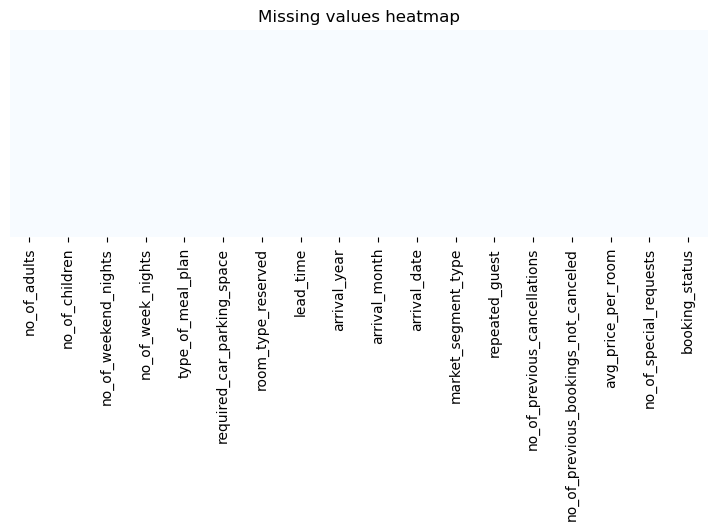

In [5]:
ExploratoryDataAnalysis.plot_missing_values_heatmap(df)

>No NaNs detected

#### Checking Duplicate Rows

In [6]:
ExploratoryDataAnalysis.has_df_duplicated_rows(df)
# Note: Standard code:
# sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = "Blues").set_title("Missing values heatmap")

🔍 Row Duplicated Analysis
⚠️  10275 duplicates found (28.33%)
    Total rows affected: 10,275/36,275


{'total_rows': 36275,
 'duplicates_count': 10275,
 'duplicates_pct': 0.2832529290144728}

> We have no duplicated rows

#### Checking Outlier Values

In [7]:
def automated_outlier_detection(df, exclude_columns=None, min_unique_values=3,
                               show_exclusion_info=True, include_zero_outliers=False):
    """
    Automated outlier detection using the Interquartile Range (IQR) method with intelligent filtering.
    
    The IQR method identifies outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR,
    where Q1 is the 25th percentile, Q3 is the 75th percentile, and IQR = Q3 - Q1.
    
    This simplified version focuses on core outlier detection without rare binary variable filtering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the data to analyze
    exclude_columns : list, optional
        Manual list of column names to exclude from analysis
    min_unique_values : int, default=3
        Minimum number of unique values required for a variable to be included in analysis.
        Variables with fewer unique values will be automatically excluded.
    show_exclusion_info : bool, default=True
        Whether to display detailed information about automatically excluded variables
    include_zero_outliers : bool, default=False
        Whether to include variables with zero outliers in the final results
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing outlier analysis results with columns:
        - Feature: Variable name
        - DataType: Data type of the variable
        - Method: Detection method used ('IQR' or '3-sigma')
        - Outlier Count: Number of outliers detected
        - Outlier %: Percentage of outliers in the dataset
        - Lower Bound: Calculated lower bound for outliers
        - Upper Bound: Calculated upper bound for outliers
        - Min Value: Minimum value in the variable
        - Max Value: Maximum value in the variable
        - IQR: Interquartile range value
    
    Methodology:
    ------------
    1. Selects numeric variables from the DataFrame
    2. Applies intelligent filtering to exclude unsuitable variables:
       - Variables with insufficient unique values
       - Constant variables (zero variance)
    3. For each suitable variable, calculates outliers using:
       - Standard IQR method for variables with sufficient variability
       - 3-sigma method (mean ± 3*std) for variables with IQR = 0
    4. Returns comprehensive results sorted by outlier count
    
    Example:
    --------
    >>> results = automated_outlier_detection(df=employee_data, min_unique_values=3)
    >>> print(results)
    """
    
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns.tolist()
    
    # Exclude manually specified columns
    if exclude_columns:
        numeric_columns = [col for col in numeric_columns if col not in exclude_columns]
    
    # Intelligent automatic filtering system
    excluded_columns = []
    columns_to_analyze = []
    
    for col in numeric_columns:
        unique_count = df[col].nunique()
        
        exclusion_reason = None
        
        # 1. Check minimum unique values requirement
        if unique_count < min_unique_values:
            exclusion_reason = f"insufficient_unique_values ({unique_count} < {min_unique_values})"
        
        # 2. Always exclude constants (zero variance)
        elif unique_count <= 1:
            exclusion_reason = "constant_variable"
        
        if exclusion_reason:
            excluded_columns.append((col, exclusion_reason))
        else:
            columns_to_analyze.append(col)
    
    # Display exclusion information
    if show_exclusion_info and excluded_columns:
        print(f"🔍 Analyzing {len(columns_to_analyze)} of {len(numeric_columns)} numeric variables")
        print("📊 Automatically excluded variables:")
        for col, reason in excluded_columns:
            print(f"   - {col}: {reason}")
    elif show_exclusion_info:
        print(f"🔍 Analyzing {len(columns_to_analyze)} numeric variables")
        print("✅ No variables were automatically excluded")
    
    # Outlier analysis
    outlier_results = []
    
    for feature in columns_to_analyze:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Choose detection method based on data variability
        if IQR == 0:
            # Alternative method for low-variability variables
            mean_val = df[feature].mean()
            std_val = df[feature].std()
            lower_bound = mean_val - 3 * std_val if std_val > 0 else mean_val
            upper_bound = mean_val + 3 * std_val if std_val > 0 else mean_val
            method_used = "3-sigma"
        else:
            # Standard IQR method
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            method_used = "IQR"
        
        # Detect outliers
        outliers_mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        outliers = df[feature][outliers_mask]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        # Include in results based on user preference
        if outlier_count > 0 or include_zero_outliers:
            outlier_results.append({
                "Feature": feature,
                "DataType": str(df[feature].dtype),
                "Method": method_used,
                "Outlier Count": outlier_count,
                "Outlier %": f"{outlier_percentage:.2f}%",
                "Lower Bound": round(lower_bound, 2),
                "Upper Bound": round(upper_bound, 2),
                "Min Value": df[feature].min(),
                "Max Value": df[feature].max(),
                "IQR": round(IQR, 2) if IQR > 0 else 0
            })
    
    # Create and sort results DataFrame
    result_df = pd.DataFrame(outlier_results)
    if not result_df.empty:
        result_df = result_df.sort_values('Outlier Count', ascending=False)
    
    return result_df

In [8]:
# The IQR method identifies outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR,
#  where Q1 is the 25th percentile, Q3 is the 75th percentile, and IQR = Q3 - Q1.
# This simplified version focuses on core outlier detection without rare binary variable filtering.

results_default = automated_outlier_detection(
    df=df,
    min_unique_values=3,
    show_exclusion_info=True)

results_default

🔍 Analyzing 11 of 14 numeric variables
📊 Automatically excluded variables:
   - required_car_parking_space: insufficient_unique_values (2 < 3)
   - arrival_year: insufficient_unique_values (2 < 3)
   - repeated_guest: insufficient_unique_values (2 < 3)


,Feature,DataType,Method,Outlier Count,Outlier %,Lower Bound,Upper Bound,Min Value,Max Value,IQR
7,avg_price_per_room,float64,IQR,1696,4.68%,20.75,179.55,0.0,540.0,39.7
4,lead_time,int64,IQR,1331,3.67%,-146.50,289.50,0.0,443.0,109.0
1,no_of_children,int64,3-sigma,1080,2.98%,-1.10,1.31,0.0,10.0,0.0
8,no_of_special_requests,int64,IQR,761,2.10%,-1.50,2.50,0.0,5.0,1.0
3,no_of_week_nights,int64,IQR,324,0.89%,-2.00,6.00,0.0,17.0,2.0
6,no_of_previous_bookings_not_canceled,int64,3-sigma,267,0.74%,-5.11,5.42,0.0,58.0,0.0
0,no_of_adults,int64,3-sigma,155,0.43%,0.29,3.40,0.0,4.0,0.0
5,no_of_previous_cancellations,int64,3-sigma,140,0.39%,-1.08,1.13,0.0,13.0,0.0
2,no_of_weekend_nights,int64,IQR,21,0.06%,-3.00,5.00,0.0,7.0,2.0


In [9]:
results_default.Feature

7                      avg_price_per_room
4                               lead_time
1                          no_of_children
8                  no_of_special_requests
3                       no_of_week_nights
6    no_of_previous_bookings_not_canceled
0                            no_of_adults
5            no_of_previous_cancellations
2                    no_of_weekend_nights
Name: Feature, dtype: object

#### Data Quality Insights: Missing Values, Duplicates and Outliers

**Missing Values**
-   no detected 

**Duplicated Records**
-   no detected

**Outlier Values**  
We have outliers as values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
Top 5 features with less than 5% of their data: `avg_price_per_room`,`lead_time`,`no_of_children`,`no_of_special_requests`,`no_of_week_nights`.

> At the moment we just recomend an scaller as preprocess only

## Exploratory Data Analysis (EDA)

### 1. Preliminary Analysis and Structure

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

In [11]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [12]:
categorical_columns, non_categorical_columns = GeneralFeatureEngineering.detect_categorical_and_non_categorical_columns(df)

Categorical Columns:     ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']
Non-Categorical Columns: ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [13]:
df.head(3)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


### 2. Univariate Analysis

#### 2.1. Non-Categorical Variables

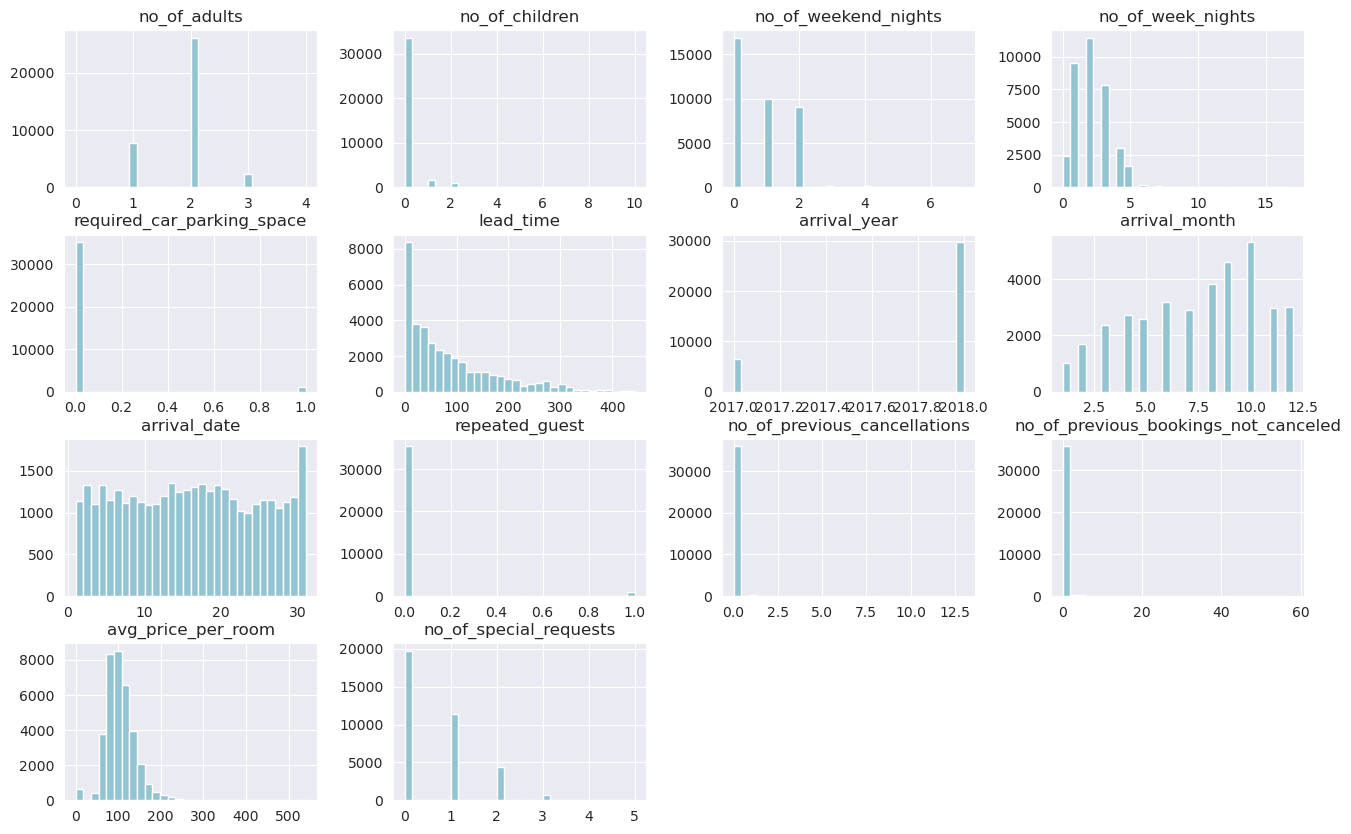

In [14]:
# Plot non categotical Variables
sns.set_style("darkgrid")
df[non_categorical_columns].hist(bins = 30, figsize=(16,10), color = '#93c4d2')
plt.show()

In [15]:
import pandas as pd

def check_skewness(data, numerical_features, highlight=True, sort=True):
    """
    Analiza la asimetría (skewness) de las variables numéricas en un DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataset de entrada.
    numerical_features : list
        Lista con los nombres de las variables numéricas.
    highlight : bool, optional (default=True)
        Si True, resalta con colores las variables con asimetría moderada o alta.
    sort : bool, optional (default=True)
        Si True, ordena las variables por |skewness| de mayor a menor.

    Returns
    -------
    skewed_features : list
        Lista de features con asimetría moderada o alta.
    skew_df : pandas.DataFrame
        DataFrame con los valores de skewness y clasificación.
    """

    # Calcular skewness
    skewness_dict = {feature: data[feature].skew(skipna=True) for feature in numerical_features}
    skew_df = pd.DataFrame.from_dict(skewness_dict, orient="index", columns=["Skewness"])

    # Clasificación
    def classify_skew(val):
        val_abs = abs(val)
        if val_abs >= 1:
            return "Highly skewed"
        elif val_abs >= 0.5:
            return "Moderately skewed"
        else:
            return "Approximately symmetric"

    skew_df["Remark"] = skew_df["Skewness"].apply(classify_skew)

    # Ordenar si corresponde
    if sort:
        skew_df = skew_df.reindex(skew_df["Skewness"].abs().sort_values(ascending=False).index)

    # Output en consola
    print("\n🔍 Skewness for dataset:")
    print("-"*70)
    print(f"{'Feature':<30} | {'Skewness':<10} | {'Remark'}")
    print("-"*70)

    skewed_features = []
    for feature, row in skew_df.iterrows():
        skew, remark = row["Skewness"], row["Remark"]

        if remark == "Highly skewed":
            color = "\033[91m" if highlight else ""
        elif remark == "Moderately skewed":
            color = "\033[93m" if highlight else ""
        else:
            color = ""
        endc = "\033[0m" if color else ""

        print(f"{color}{feature:<30} | {skew:>+10.4f} | {remark}{endc}")

        if remark != "Approximately symmetric":
            skewed_features.append(feature)

    print("-"*70)
    return skewed_features, skew_df

In [16]:
skewed_features, skew_df = check_skewness(data=df, numerical_features=non_categorical_columns)


🔍 Skewness for dataset:
----------------------------------------------------------------------
Feature                        | Skewness   | Remark
----------------------------------------------------------------------
no_of_previous_cancellations   |   +25.1999 | Highly skewed
no_of_previous_bookings_not_canceled |   +19.2502 | Highly skewed
repeated_guest                 |    +6.0029 | Highly skewed
required_car_parking_space     |    +5.4136 | Highly skewed
no_of_children                 |    +4.7103 | Highly skewed
arrival_year                   |    -1.6697 | Highly skewed
no_of_week_nights              |    +1.5994 | Highly skewed
lead_time                      |    +1.2925 | Highly skewed
no_of_special_requests         |    +1.1451 | Highly skewed
no_of_weekend_nights           |    +0.7376 | Moderately skewed
avg_price_per_room             |    +0.6671 | Moderately skewed
arrival_month                  |    -0.3482 | Approximately symmetric
no_of_adults                   |    

#### 🗒️ Insights for Non-Categorical Variables (Univariate)

**Modeling Insight** (*priority: high*):  
*Key Findings from Distributional Analysis:*

*   **Variables to Transform** (long tail distributions):
    `(no_of_previous_cancellations)`, `(no_of_previous_bookings_not_canceled)`, `(repeated_guest)`, `(required_car_parking_space)`, `(no_of_children)`, `(no_of_week_nights)`, `(lead_time)`, `(no_of_special_requests)`.
    These skewed distributions violate the normality assumptions of many models. It is recommended to apply logarithmic, Box-Cox, or binning transformations to reduce skewness and improve numerical stability.

*   **Moderately Skewed Variables**:
    `(no_of_weekend_nights)`, `(avg_price_per_room)`.
    These variables have a mild positive skew; evaluate logarithmic transformations or normalization depending on the model. For tree-based models, they can potentially remain unchanged.

*   **Approximately Symmetrical Variables**:
    `(arrival_month)`, `(no_of_adults)`, `(arrival_date)`.
    These variables can be kept as-is or normalized for models sensitive to scale (e.g., neural networks).

**Business Insight**:
The data profile shows a high concentration in variables related to previous customer behavior (`(no_of_previous_cancellations)`, `(no_of_previous_bookings_not_canceled)`, `(repeated_guest)`), indicating patterns of loyalty and cancellations. The proposed transformations will enhance the predictive capability and numerical stability of the models, preventing highly skewed variables from dominating the learning process.

#### 2.2. Categorical Variables

In [17]:
df[categorical_columns]

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,Meal Plan 1,Room_Type 1,Offline,Not_Canceled
1,Not Selected,Room_Type 1,Online,Not_Canceled
2,Meal Plan 1,Room_Type 1,Online,Canceled
3,Meal Plan 1,Room_Type 1,Online,Canceled
4,Not Selected,Room_Type 1,Online,Canceled
...,...,...,...,...
36270,Meal Plan 1,Room_Type 4,Online,Not_Canceled
36271,Meal Plan 1,Room_Type 1,Online,Canceled
36272,Meal Plan 1,Room_Type 1,Online,Not_Canceled
36273,Not Selected,Room_Type 1,Online,Canceled


In [18]:
def univariate_categorical_analysis(data, columns, figsize=(5, 4), palette='viridis', vspace=0.3):
    """
    Univariate Categorical Analysis for Exploratory Data Analysis (EDA).

    This function visualizes the distribution of categorical variables in a dataset using horizontal bar plots,
    displaying both frequency and percentage for each category. It is designed for EDA workflows to quickly
    assess the balance and prevalence of categories in each feature.

    Parameters
    ----------
    data : pandas.DataFrame
        The input DataFrame containing the data to analyze.
    columns : list of str
        List of categorical column names to visualize.
    figsize : tuple of int, optional (default=(5, 4))
        Base figure size for each subplot (width, height).
    palette : str or list, optional (default='viridis')
        Seaborn color palette or list of colors for the bars.
    vspace : float, optional (default=0.3)
        Vertical spacing between rows of subplots.

    Returns
    -------
    None
        Displays the plots directly using matplotlib.

    Notes
    -----
    - Each subplot shows the frequency and percentage of each category for a given feature.
    - Missing values are displayed as 'NaN'.
    - The function automatically arranges subplots in a 2-column layout.
    - Useful for quickly identifying imbalanced categories and potential data quality issues.
    """
    sns.set_theme(style="whitegrid")

    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2  # Calculate rows for 2-column layout
    
    # Calculate figure size based on number of rows and vertical spacing
    fig_width = figsize[0] * 2
    fig_height = figsize[1] * n_rows * (1 + vspace)
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(fig_width, fig_height))
    axes = axes.flatten()  # Flatten for easy iteration
    
    fig.suptitle('Categorical Distributions', fontsize=18, fontweight='bold', y=0.98)
    
    for idx, column in enumerate(columns):
        if idx >= len(axes):  # Safety check
            break
            
        ax = axes[idx]
        
        # Get data and handle nulls
        column_data = data[column].copy().fillna('NaN')
        
        # Calculate frequencies and percentages
        frequencies = column_data.value_counts()
        total = len(column_data)
        percentages = (frequencies / total * 100).round(1)
        
        # Create horizontal bar plot
        colors = sns.color_palette(palette, len(frequencies))
        bars = ax.barh(range(len(frequencies)), frequencies.values, color=colors, alpha=0.8)
        
        # Set y-ticks and labels
        ax.set_yticks(range(len(frequencies)))
        ax.set_yticklabels(frequencies.index)
        
        # Add count and percentage values on bars
        for i, (value, percentage) in enumerate(zip(frequencies.values, percentages.values)):
            ax.text(value + value * 0.01, i, f'{value} ({percentage}%)', 
                   va='center', fontweight='bold', fontsize=11)
        
        ax.set_title(column, fontsize=14, fontweight='bold')
        ax.set_xlabel('Frequency')
        
        # Add some padding for text
        max_freq = max(frequencies.values)
        ax.set_xlim(0, max_freq * 1.15)
    
    # Hide empty subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)
    
    # Adjust layout with customizable vertical spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=vspace)  # Use the vspace parameter
    plt.show()

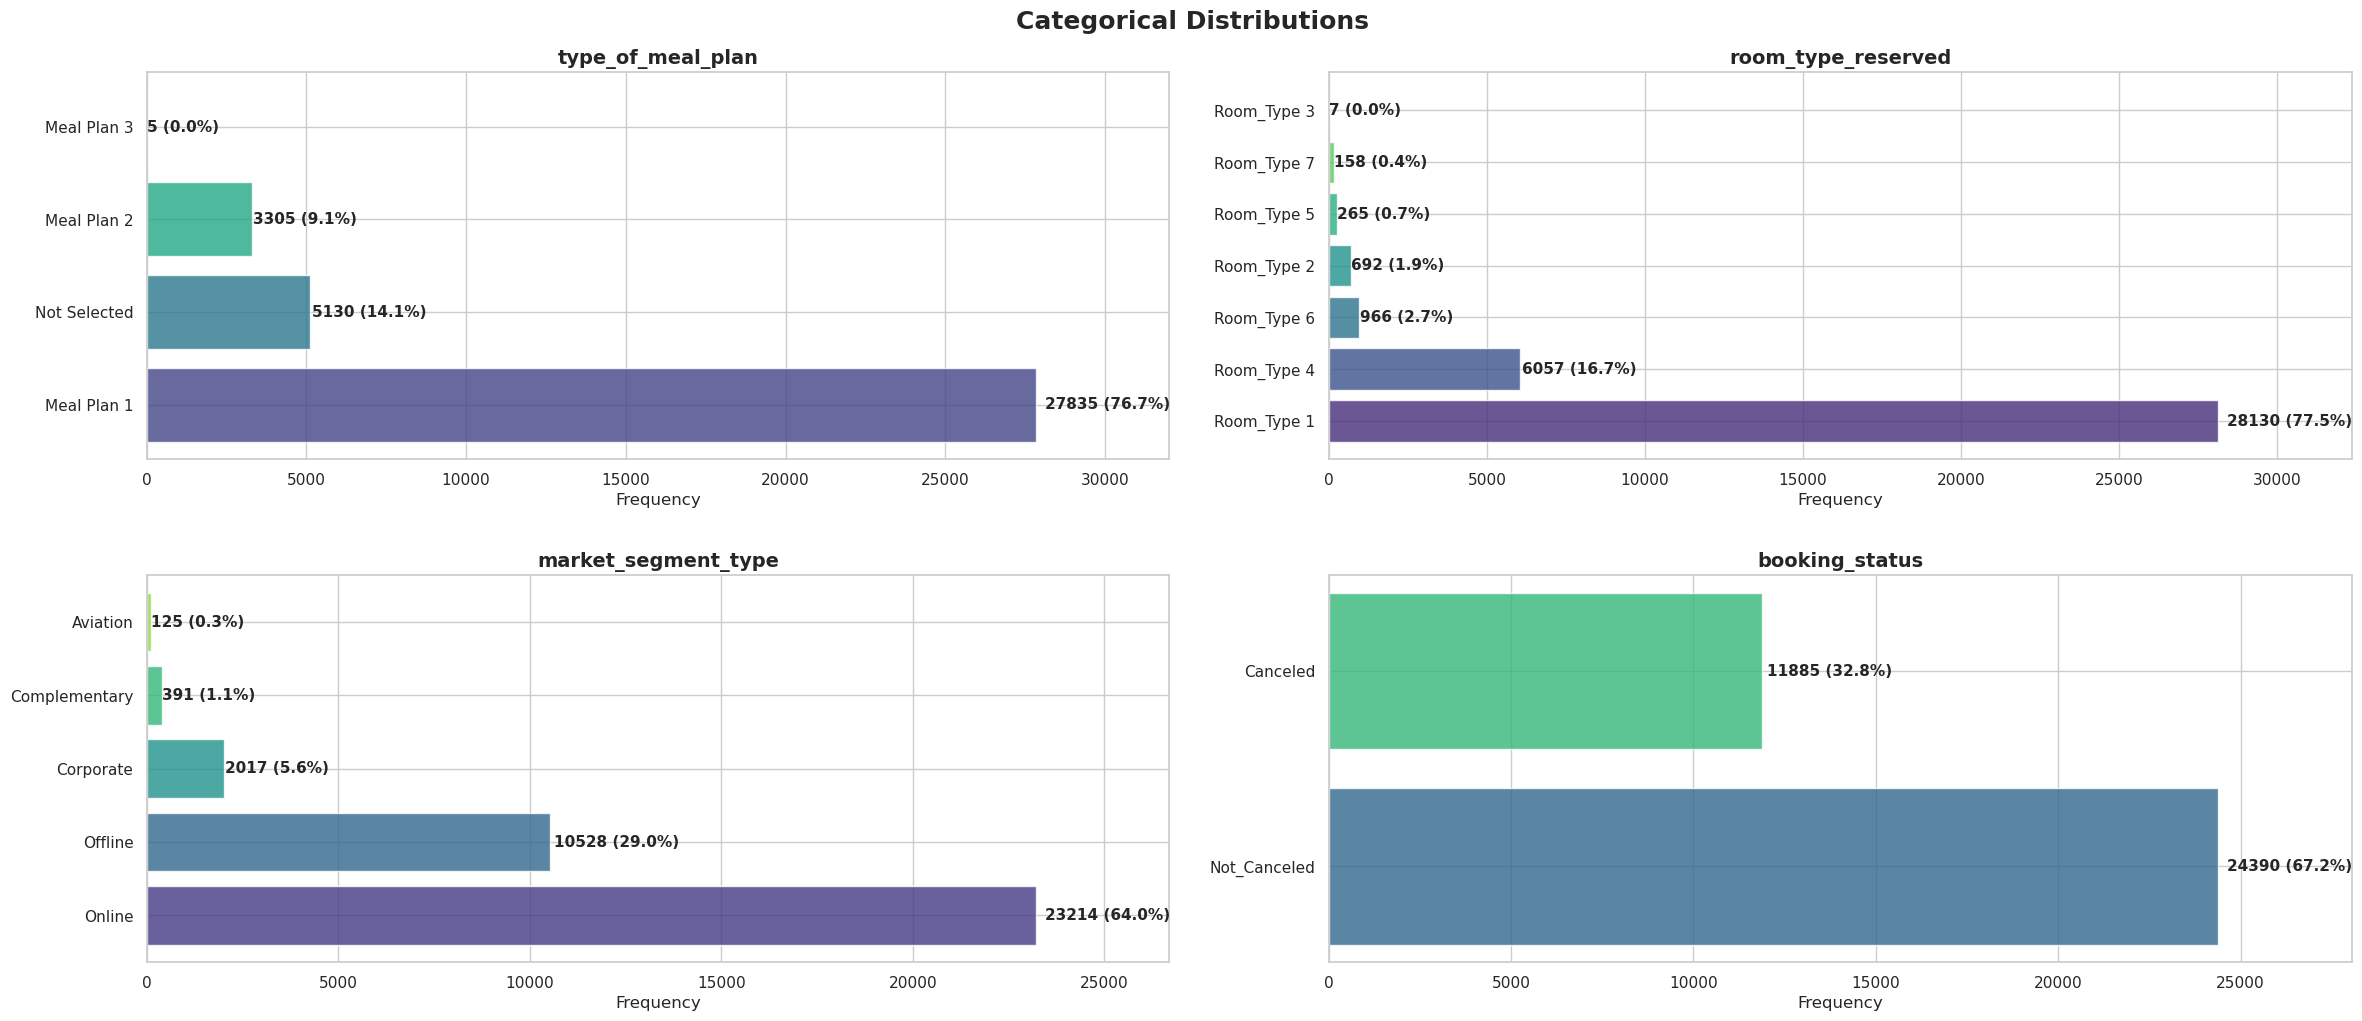

In [19]:
univariate_categorical_analysis(data=df, columns=categorical_columns, figsize=(12, 4))

#### 🗒️ Insights for Categorical Variables (Univariate)

`(type_of_meal_plan)`
- **Modeling Insight** (*priority: high*): Severe class imbalance with Meal Plan 1 (76.7%) dominating; requires encoding and potential class balancing techniques.
- **Business Insight**: Strong customer preference for Meal Plan 1, indicating it may be the most popular or standard offering.

`(room_type_reserved)`
- **Modeling Insight** (*priority: high*): Extreme class imbalance with Room_Type 1 (77.5%) dominating; consider encoding and evaluate impact of rare categories.
- **Business Insight**: Room_Type 1 is the clear customer preference, suggesting it's either the standard room or offers the best value.

`(market_segment_type)`
- **Modeling Insight** (*priority: medium*): Moderate imbalance with Online (64.0%) and Offline (29.0%) segments dominating; requires categorical encoding.
- **Business Insight**: Online channels drive most bookings, followed by offline channels, indicating digital marketing effectiveness.

`(booking_status)`
- **Modeling Insight** (*priority: high*): Target variable with class imbalance - 32.8% canceled (1) vs 67.2% not canceled (0); requires balancing techniques like SMOTE or class weights.
- **Business Insight**: Approximately one-third of bookings result in cancellations, indicating significant revenue protection opportunity.

**Global Preprocessing Summary**
- **Categorical Variables (One-Hot Encoding)**: `(type_of_meal_plan)`, `(room_type_reserved)`, `(market_segment_type)`
- **Target Imbalance**: `(booking_status)` (32.8% vs 67.2%) - apply SMOTE, class weights, or other balancing techniques
- **Other Preprocessing Notes**: All categorical variables show significant class imbalance; consider rare category handling or target encoding

### 3. Bivariate/Multivariate Analysis with Target
- Distribution comparisons (numerical vs target)
- Target proportions by category (categorical vs target)
- Correlation matrices (Pearson, Spearman)

#### 3.1. Between Non-Categorical Variables

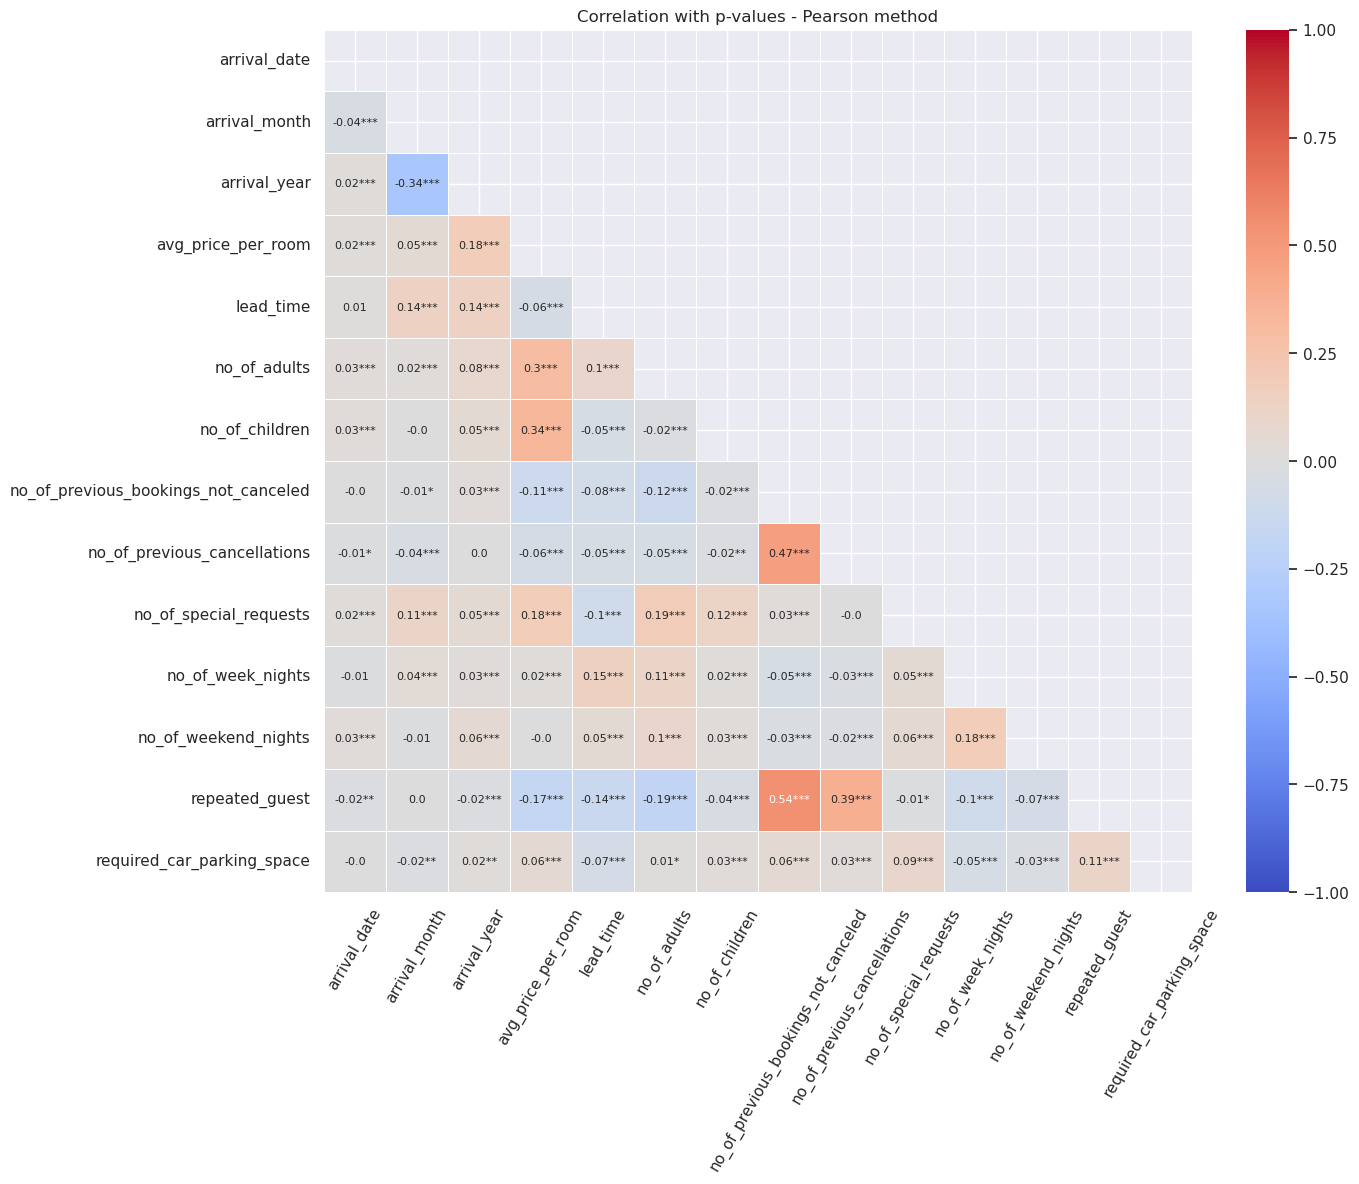

In [20]:
# Pearson correlation
corr_table = NonCategoricalFeatureEngineering.table_of_correlation_and_pvalues(df, method='pearson')
NonCategoricalFeatureEngineering.plot_correlation_heatmap(corr_table, method='Pearson', annotation=True)

# Note, this own library used has better style and have more information (represent p-value as *)
# The standard code is:
# plt.figure(figsize=(10,5))
# sns.heatmap(df.corr(method='pearson', numeric_only=True),annot=True, fmt=".1f")

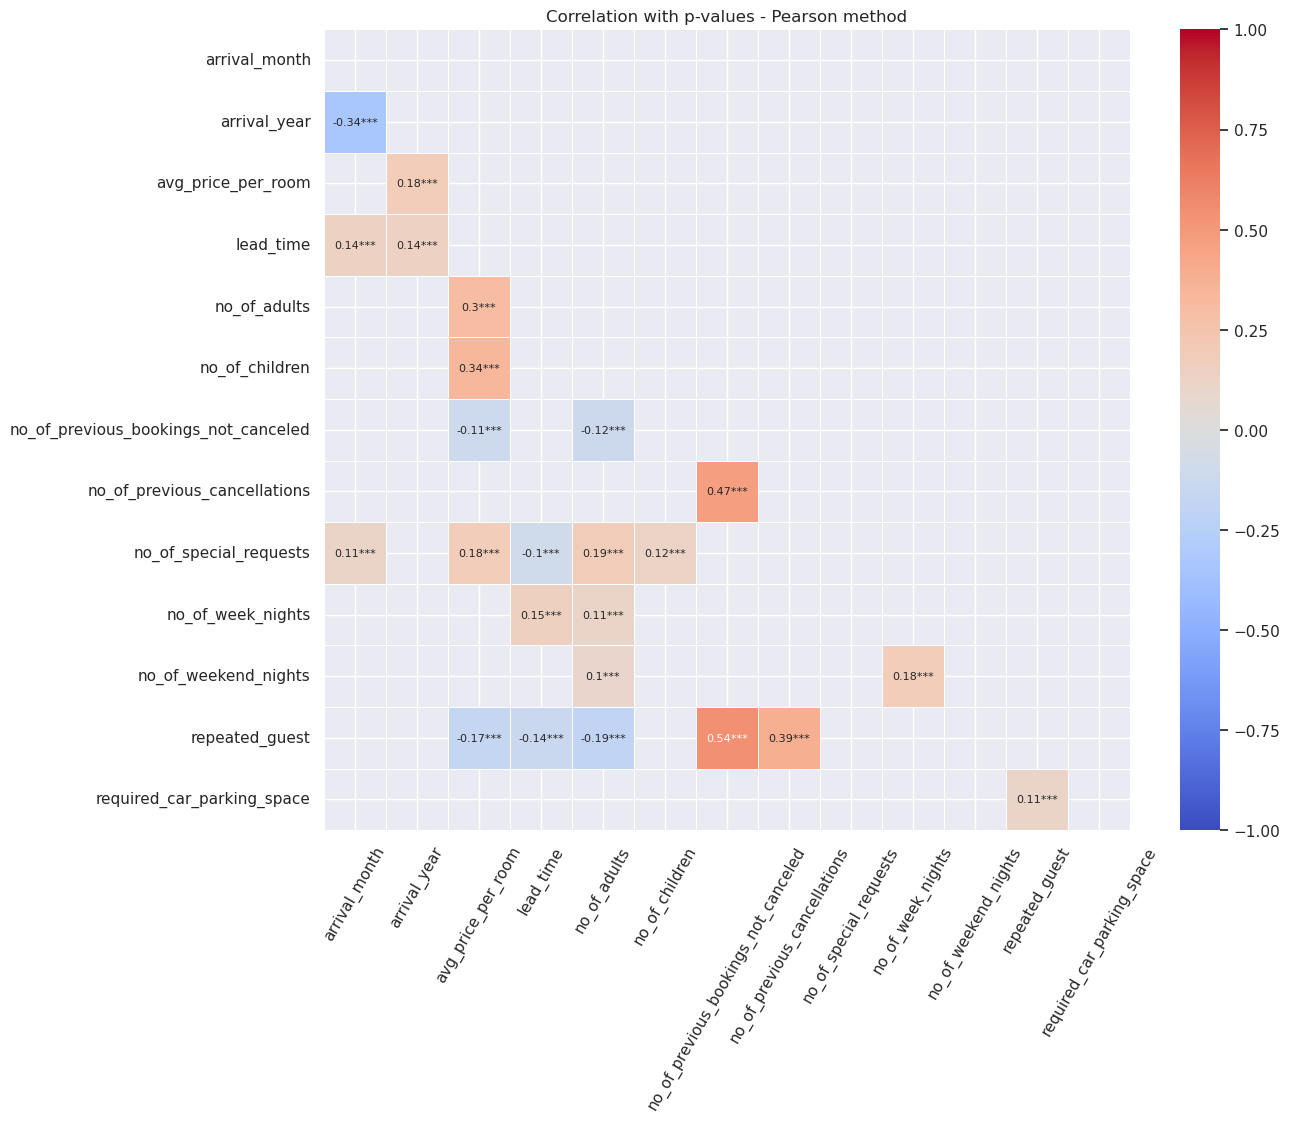

In [21]:
# We analyze correlations using Pearson's method, visualizing only those greater than 10% (correlation_limit=0.1) and with statistical significance.
# Filtered by correlation_limit=0.1, pvalue_limit=0.001

corr_table = NonCategoricalFeatureEngineering.table_of_correlation_and_pvalues(df, method='pearson')
corr_table_filtered, excluded_df = NonCategoricalFeatureEngineering.filter_corr_dataframe(corr_table,correlation_limit=0.1, pvalue_limit=0.001)
NonCategoricalFeatureEngineering.plot_correlation_heatmap(corr_table_filtered, method='Pearson', annotation=True)

In [22]:
excluded_df

,feature_1,feature_2,fails,p_value_discrepancy,correlation_discrepancy
0,no_of_adults,no_of_adults,p_value,NaN,NaN
1,no_of_adults,no_of_children,correlation,NaN,0.080213
4,no_of_adults,required_car_parking_space,both,0.028502,0.088571
5,no_of_adults,lead_time,correlation,NaN,0.002713
6,no_of_adults,arrival_year,correlation,NaN,0.023281
...,...,...,...,...,...
98,no_of_previous_cancellations,no_of_special_requests,both,0.526515,0.096683
99,no_of_previous_bookings_not_canceled,no_of_previous_bookings_not_canceled,p_value,NaN,NaN
101,no_of_previous_bookings_not_canceled,no_of_special_requests,correlation,NaN,0.072623
102,avg_price_per_room,avg_price_per_room,p_value,NaN,NaN


In [23]:
def summarize_exclusions(exclusions_df: pd.DataFrame) -> pd.DataFrame:
    # Flatten the feature pairs into a long format
    features_long = pd.melt(
        exclusions_df,
        id_vars=['fails', 'p_value_discrepancy', 'correlation_discrepancy'],
        value_vars=['feature_1', 'feature_2'],
        value_name='feature'
    )[["feature", "fails", "p_value_discrepancy", "correlation_discrepancy"]]
    
    # Aggregate stats
    summary = (
        features_long
        .groupby("feature")
        .agg(
            total_fails=("fails", "count"),
            both_fails=("fails", lambda x: (x == "both").sum()),
            corr_fails=("fails", lambda x: (x == "correlation").sum()),
            pval_fails=("fails", lambda x: (x == "p_value").sum()),
            mean_corr_discrepancy=("correlation_discrepancy", "mean"),
            mean_pval_discrepancy=("p_value_discrepancy", "mean"),
            max_corr_discrepancy=("correlation_discrepancy", "max"),
            max_pval_discrepancy=("p_value_discrepancy", "max"),
        )
        .sort_values("total_fails", ascending=False)
        .reset_index()
    )

    # Optional: rank features by combined discrepancy severity
    summary["severity_score"] = (
        summary["total_fails"] +
        summary["mean_corr_discrepancy"].fillna(0) * 10 +
        summary["mean_pval_discrepancy"].fillna(0) * 10
    )

    return summary.sort_values("severity_score", ascending=False)
    
summarize_exclusions(excluded_df)

,feature,total_fails,both_fails,corr_fails,pval_fails,mean_corr_discrepancy,mean_pval_discrepancy,max_corr_discrepancy,max_pval_discrepancy,severity_score
0,arrival_date,15,6,7,2,0.082861,0.346111,0.099963,0.993406,19.289720
1,required_car_parking_space,14,4,8,2,0.061385,0.256467,0.099963,0.993406,17.178521
4,no_of_children,13,2,9,2,0.072412,0.278880,0.096924,0.556962,16.512923
2,no_of_previous_cancellations,13,4,7,2,0.071896,0.249413,0.096683,0.526515,16.213085
5,arrival_month,12,5,5,2,0.076543,0.321012,0.099659,0.947207,15.975548
3,no_of_weekend_nights,13,2,9,2,0.065549,0.223181,0.095475,0.387837,15.887295
8,no_of_previous_bookings_not_canceled,11,2,7,2,0.066133,0.407298,0.098502,0.774376,15.734305
7,arrival_year,12,2,8,2,0.065301,0.228124,0.096081,0.454433,14.934255
11,avg_price_per_room,9,1,6,2,0.059023,0.387837,0.095475,0.387837,13.468602
10,no_of_special_requests,10,2,6,2,0.061428,0.274944,0.096683,0.526515,13.363719


Text(0.5, 1.0, 'Booking Distribution By The Days Of Months')

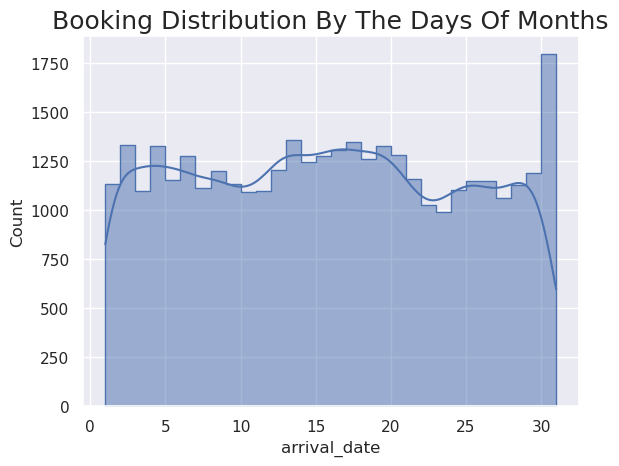

In [24]:
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. 
# KDE represents the data using a continuous probability density curve in one or more dimensions.
sns.histplot(data= df, x= "arrival_date", element="step", kde=True, bins=30)
plt.title("Booking Distribution By The Days Of Months",fontsize=18)

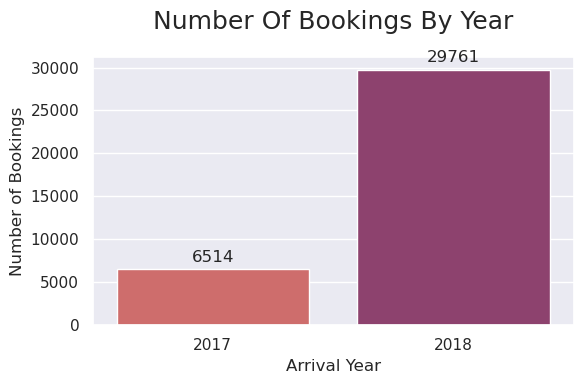

In [25]:
# Ensure arrival_year is numeric and handle potential missing values
df['arrival_year'] = pd.to_numeric(df['arrival_year'], errors='coerce')
df = df.dropna(subset=['arrival_year'])

# Create the countplot using seaborn
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='arrival_year', palette='flare', order=sorted(df['arrival_year'].unique()))

# Add annotations using bar_label (cleaner approach)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12) # type: ignore

plt.title("Number Of Bookings By Year", fontsize=18, pad=20)
plt.xlabel("Arrival Year")
plt.ylabel("Number of Bookings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

> Our samples are mostly from 2018

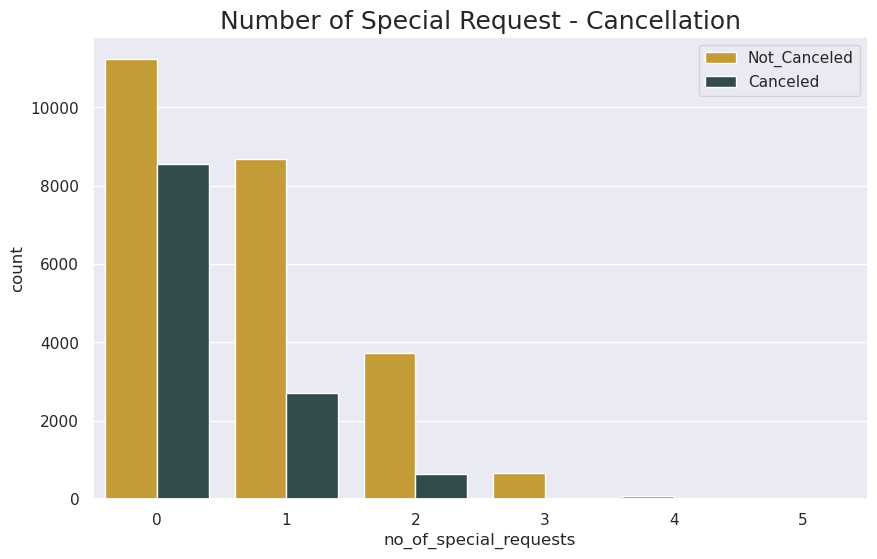

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(x=df.no_of_special_requests, hue=df.booking_status,palette=sns.color_palette(["#daa520","#2f4f4f"]))
plt.title("Number of Special Request - Cancellation",fontsize=18);
plt.legend(loc="upper right")

> We can say that as the lead time increases the possibility of canceling increases
> The cancelation rate is higher for the guests who don't have a special request compare to others.

#### 🗒️ Insights for Non Categorical - without Target

`(required_car_parking_space)`
- **Modeling Insight** (*priority: low*): Weak positive correlation with repeated_guest (r=0.11); minimal multicollinearity concern.
- **Business Insight**: Slight association between requiring parking and being a repeat guest.

`(lead_time)`
- **Modeling Insight** (*priority: high*): Moderate correlations with arrival_year (r=0.14), arrival_month (r=0.14), and negative with repeated_guest (r=-0.14); key predictor requiring careful handling.
- **Business Insight**: Longer lead times show seasonal patterns and negative association with repeat guests.

`(arrival_year)`
- **Modeling Insight** (*priority: medium*): Strong negative correlation with arrival_month (r=-0.34); moderate correlation with avg_price_per_room (r=0.18).
- **Business Insight**: Year shows strong inverse relationship with month and relationship with pricing.

`(arrival_month)`
- **Modeling Insight** (*priority: low*): Weak correlation with avg_price_per_room (r=0.11); strong negative correlation with arrival_year (r=-0.34).
- **Business Insight**: Monthly variations show minor relationship with room pricing.

`(repeated_guest)`
- **Modeling Insight** (*priority: high*): Strong positive correlations with no_of_previous_bookings_not_canceled (r=0.54) and no_of_previous_cancellations (r=0.39); negative with no_of_adults (r=-0.19).
- **Business Insight**: Repeat guests show distinct booking history patterns and tend to book for fewer adults.

`(avg_price_per_room)`
- **Modeling Insight** (*priority: high*): Correlated with no_of_adults (r=0.30), no_of_children (r=0.34), and no_of_special_requests (r=0.18); may require scaling.
- **Business Insight**: Room pricing strongly relates to group size (both adults and children) and special requests.

`(no_of_special_requests)`
- **Modeling Insight** (*priority: medium*): Positive correlations with no_of_adults (r=0.19), no_of_children (r=0.12), and avg_price_per_room (r=0.18).
- **Business Insight**: More special requests associated with larger groups and higher room prices.

`(no_of_adults)`
- **Modeling Insight** (*priority: medium*): Multiple correlations including positive with avg_price_per_room (r=0.30) and negative with repeated_guest (r=-0.19).
- **Business Insight**: Number of adults relates to room pricing and repeat guest status.

**Global Preprocessing Summary**
- **Transformations Recommended**: `lead_time`, `avg_price_per_room` (consider scaling due to correlation patterns)
- **Other Preprocessing Notes**: Monitor multicollinearity among `repeated_guest`, booking history variables, and group size variables; consider feature engineering for `no_of_people` as composite feature

**Non Categorical vs Target analysis**

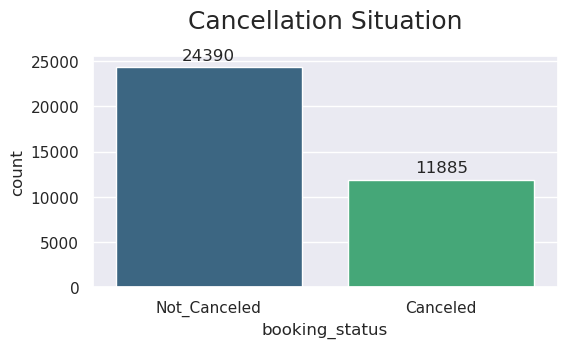

In [27]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df, x='booking_status', palette='viridis')

# Label ALL containers (bars)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12)  # type: ignore

plt.title("Cancellation Situation", fontsize=18, pad=20)
plt.subplots_adjust(top=0.88)
plt.show()

> Canceled and Not canceled classes were not distributed balanced so it may cause an imbalanced dataset problem. I will check it out.

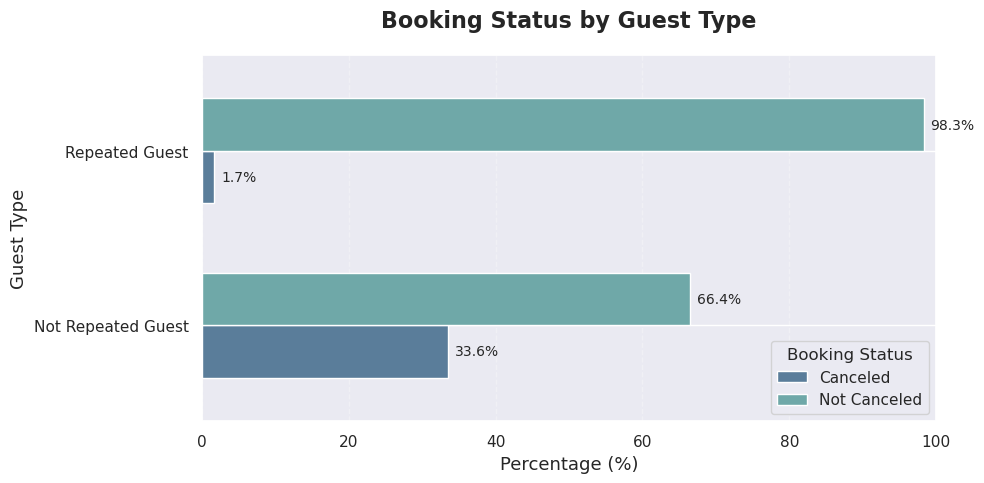

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

# First create the grouped data
grouped = (
    df.groupby('repeated_guest')['booking_status']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

# Then plot it
grouped.plot(
    kind='barh',
    color=['#5a7d9a', '#6fa8a8'],  # Viridis-inspired colors
    ax=ax,
    width=0.6
)

ax.set_title('Booking Status by Guest Type', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Percentage (%)', fontsize=13)
ax.set_ylabel('Guest Type', fontsize=13)
ax.legend(title='Booking Status', loc='lower right', fontsize=11, labels=['Canceled', 'Not Canceled'])
ax.set_yticklabels(['Not Repeated Guest', 'Repeated Guest'])
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=5, fontsize=10)   # type: ignore

plt.tight_layout()
plt.show()

> The cancelation rate is higher for not repeated guest compare to repeated ones.
> Most of the repeated guest did not cancel their booking.

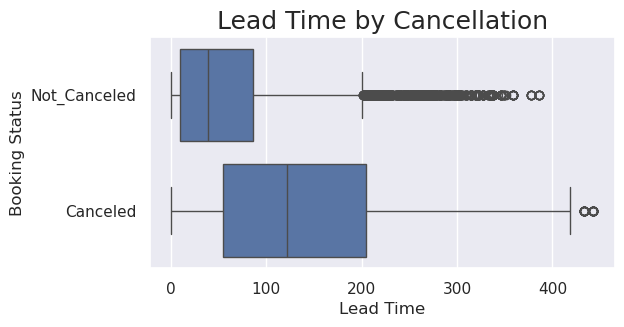

In [29]:

fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df, y="booking_status", x="lead_time")
plt.title("Lead Time by Cancellation", fontsize=18)
plt.xlabel("Lead Time", fontsize=12)
plt.ylabel("Booking Status", fontsize=12)
plt.show()

#### 🗒️ Insights for Non Categorical - with Target

`(booking_status)`
- **Modeling Insight** (*priority: high*): Significant class imbalance - Canceled (11,885) vs Not_Canceled (24,390); requires balancing techniques.
- **Business Insight**: The booking cancellation rate shows substantial business impact, with nearly one-third of bookings being canceled.

`(repeated_guest)`
- **Modeling Insight** (*priority: medium*): Categorical variable showing strong correlation with target; may require encoding and should be considered as important feature.
- **Business Insight**: Repeat guests have significantly lower cancellation rates (1.7%) compared to new guests (33.6%), indicating loyalty reduces cancellation risk.

`(lead_time)`
- **Modeling Insight** (*priority: high*): Numerical variable showing different distributions between canceled and non-canceled bookings; may require scaling/normalization and could be a strong predictor.
- **Business Insight**: Booking lead time appears to correlate with cancellation likelihood, suggesting that earlier bookings may have different cancellation patterns than last-minute bookings.

**Global Preprocessing Summary**
- **Transformations**: Recommended: `(lead_time)` (scaling/normalization due to wide range and predictive importance).
- **Target Imbalance**: `(booking_status)` — apply SMOTE, undersampling, or class-weight adjustment due to significant class imbalance.
- **Categorical Variables (One-Hot Encoding)**: `(repeated_guest)`.
- **Other Preprocessing Notes**: `(repeated_guest)` shows strong predictive power for the target variable and should be prioritized in feature selection.

#### 3.2. Between Categorical Variables

In [30]:
chi_square_analysis = CategoricalFeatureEngineering.chi_square_analysis(df=df, categorical_columns=categorical_columns) # ['type_of_meal_plan', 'market_segment_type']
chi_square_analysis

,variable_1,variable_2,chi2_statistic,p_value,degrees_of_freedom,sample_size,is_significant,min_expected_freq,cells_below_5,assumption_ok,recommendation,contingency_shape
0,type_of_meal_plan,room_type_reserved,2350.787808,0.000000e+00,18,36275,True,0.000965,9,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x7
1,type_of_meal_plan,market_segment_type,5703.046688,0.000000e+00,12,36275,True,0.017229,5,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x5
2,type_of_meal_plan,booking_status,278.294909,4.951915e-60,3,36275,True,1.638181,2,False,DO NOT APPLY Cramer's V - Assumptions violated...,4x2
3,room_type_reserved,market_segment_type,3950.438201,0.000000e+00,24,36275,True,0.024121,11,False,DO NOT APPLY Cramer's V - Assumptions violated...,7x5
4,room_type_reserved,booking_status,57.334952,1.562780e-10,6,36275,True,2.293453,2,True,APPLY Cramer's V - Significant association fou...,7x2
5,market_segment_type,booking_status,814.108865,6.748763e-175,4,36275,True,40.954514,0,True,APPLY Cramer's V - Significant association fou...,5x2


In [31]:
print(chi_square_analysis.recommendation.values)

["DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "DO NOT APPLY Cramer's V - Assumptions violated. The significant p-value may be unreliable. Consider combining categories or using Fisher's Exact Test."
 "APPLY Cramer's V - Significant association found and test assumptions are met. Proceed to measure the strength of the association."
 "APPLY Cramer's V - Significant association found and test assumptions are met. Proceed to measure the strength of the association."]


In [32]:
recommended_pairs = CategoricalFeatureEngineering.get_recommended_pairs_for_cramers_v(chi_square_analysis)
print(recommended_pairs)

[('room_type_reserved', 'booking_status'), ('market_segment_type', 'booking_status')]


These are the only categorical features with significant association to make a Cramer´s V test:  
`['(room_type_reserved)','(market_sergment_type)','(booking_status)']`


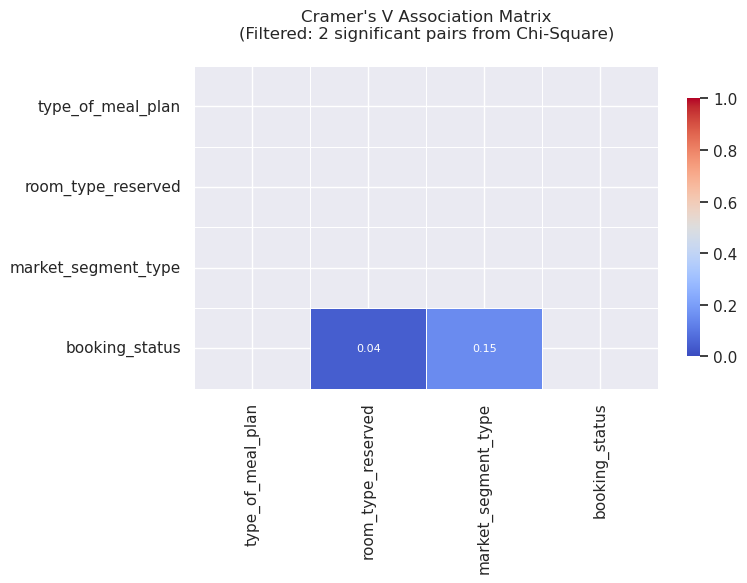

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
type_of_meal_plan,NaN,NaN,NaN,NaN
room_type_reserved,NaN,1.000000,NaN,0.039756
market_segment_type,NaN,NaN,1.000000,0.149809
booking_status,NaN,0.039756,0.149809,1.000000


In [33]:
CategoricalFeatureEngineering.cramers_v_correlations(df=df, cat_vars=categorical_columns, relevant_chi_square_pairs= recommended_pairs)

#### 🗒️ Insights for Categorical

`(room_type_reserved)`
- **Modeling Insight** (*priority: medium*): Categorical variable with some significant association to target (Cramer's V: 0.15); check as predictive feature with other method.
- **Business Insight**: Different room types show varying cancellation patterns, suggesting room preference influences booking stability.

`(market_segment_type)`
- **Modeling Insight** (*priority: medium*): Categorical variable with significant association to target; requires encoding and contributes predictive power to the model.
- **Business Insight**: Booking channels or market segments exhibit different cancellation behaviors, indicating marketing source affects booking reliability.

`(type_of_meal_plan)`
- **Modeling Insight** (*priority: low*): Categorical variable with weak association to target (Cramer's V: 0.04); may have limited predictive value.
- **Business Insight**: Meal plan selection shows minimal correlation with cancellation behavior.

#### 3.3. Between Non-Categorical and Categorical Variables (Features Only)

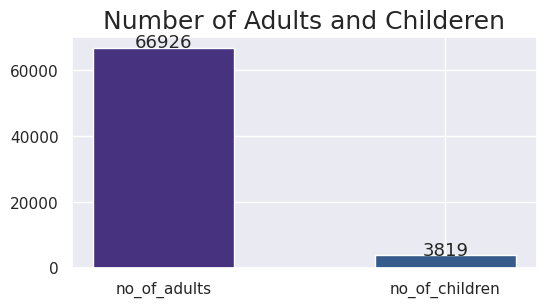

In [34]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(np.arange(2),[df.no_of_adults.sum(),df.no_of_children.sum()],width=0.5, color=sns.color_palette("viridis"))
plt.xticks(np.arange(2),("no_of_adults","no_of_children"))

plt.title("Number of Adults and Childeren",fontsize=18);
for i, v in enumerate([df.no_of_adults.sum(),df.no_of_children.sum()]):
    ax.text(i, v + 0.5, str(v), ha='center',fontsize=13)

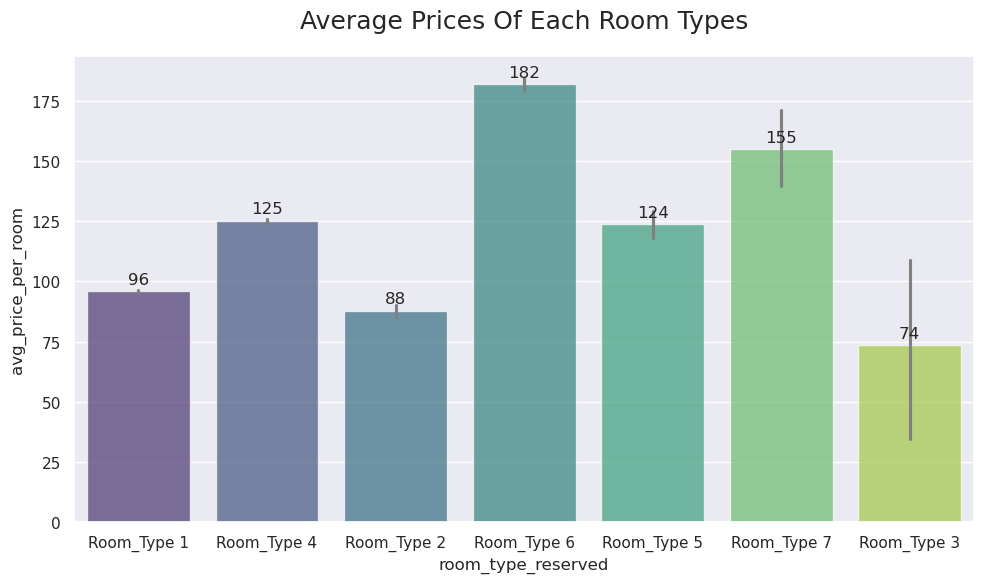

In [35]:
plt.figure(figsize=(10,6))

ax = sns.barplot(x=df.room_type_reserved, 
                 y=df.avg_price_per_room,
                 palette="viridis",
                 alpha=0.7,
                 #errorbar="ci", # Confidence Interval (sns uses Bootstrapping method)
                 errcolor="0.5")

plt.title("Average Prices Of Each Room Types", fontsize=18, pad=20)

# Improved annotation using bar_label
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=12) # type: ignore

plt.tight_layout()
plt.show()

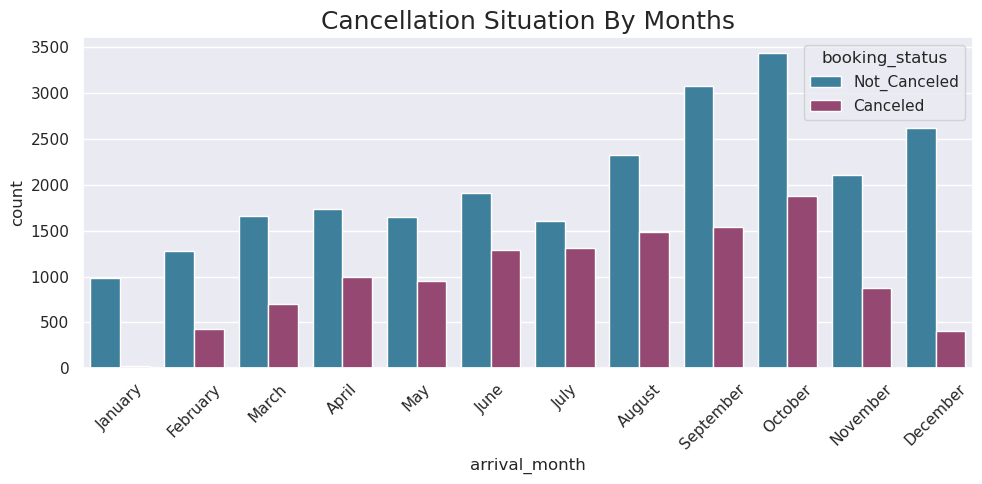

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.arrival_month, hue=df.booking_status, 
              palette=["#2E86AB", "#A23B72"])  # Professional blue & burgundy
plt.xticks(np.arange(0,12), ["January","February","March","April","May","June",
                           "July","August","September","October","November","December"], 
           rotation=45)
plt.title("Cancellation Situation By Months", fontsize=18)
plt.tight_layout()
plt.show()

> Then, in feature ingineering, we will create from arrival_month a new binary feature acording monthly_rates of cancelation.

#### 🗒️ Insights Non-Categorical and Categorical Variables

`(no_of_adults)`
- **Modeling Insight** (*priority: medium*): Numerical count variable with wide range (1-6+ adults); may require scaling and outlier treatment for large group bookings.
- **Business Insight**: Number of adults in booking affects room configuration and pricing, potentially influencing cancellation decisions.

`(no_of_children)`
- **Modeling Insight** (*priority: medium*): Numerical count variable with many zero values; may require treatment for sparse distribution and potential encoding as categorical.
- **Business Insight**: Presence and number of children may indicate family travel patterns with different cancellation behaviors than adult-only bookings.

`(avg_price_per_room)`
- **Modeling Insight** (*priority: high*): Numerical variable showing significant price variation across room types (Range: ~25-175); requires scaling and may benefit from log transformation if skewed.
- **Business Insight**: Room pricing varies substantially by room type, with premium rooms costing significantly more, which may affect cancellation likelihood.

`(arrival_month)`
- **Modeling Insight** (*priority: high*): Categorical/ordinal variable showing seasonal cancellation patterns; **should be encoded** and used to create binary feature based on monthly cancellation rates.
- **Business Insight**: Booking cancellations show clear seasonal patterns across months, suggesting business cycles and seasonal demand affect booking stability.

## Feature Ingineering
- Selection of relevant features
- Creation of new features
- Dimensionality reduction (if applicable)

### Target Column = booking_status
* I will do encoding, take "Not_Canceled" as 0 and "Canceled" as 1.

In [37]:
df.booking_status = df.booking_status.replace({"Not_Canceled":0, "Canceled":1})

### "no_of_adults" and "no_of_children"
* I will use PCA method for these columns because they represent similar features and have close correlation. Instead of taking one of them i aim to benefit from both.

The PCA transformation will be done inside Preprocessing Pipeline

In [38]:
# FIXME move inside Preprocessing Pipeline

In [39]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=1)
# pca_no_people = pca.fit_transform(df[["no_of_adults","no_of_children"]])
# df["no_of_people"] = pca_no_people

# df.drop(columns=["no_of_adults","no_of_children"],inplace=True)

### "no_of_weekend_nights" and "no_of_week_nights"
* I will also use PCA for these columns because of the same reason too.

The PCA transformation will be done inside Preprocessing Pipeline

In [40]:
# FIXME move inside Preprocessing Pipeline

In [41]:
# pca_no_week = pca.fit_transform(df[["no_of_weekend_nights","no_of_week_nights"]])
# df["no_of_week_days"] = pca_no_week

# df.drop(columns=["no_of_weekend_nights","no_of_week_nights"],inplace=True)

In [42]:
# df.head()

### arrival_month
* According to the countplot of arrival_month i will categorize the months like this :
* The rate of those who do not cancel to those who cancel is higher and less than near 50% (was taken 40%)
* So The higher ones i will take them as 1, others are less these will be taken as 0.

In [43]:
# Get cancellation rates with month numbers as index
monthly_rates = (
    df.groupby('arrival_month')['booking_status']
    .value_counts()
    .unstack()
    .assign(cancellation_rate=lambda x: (x[1] / x[0] * 100))
    ['cancellation_rate']
)

monthly_rates

arrival_month
1      2.424242
2     33.751962
3     42.219542
4     57.151063
5     57.454545
6     67.520921
7     81.818182
8     64.000000
9     50.048812
10    54.698865
11    41.567696
12    15.349370
Name: cancellation_rate, dtype: float64

In [44]:
monthly_rates[monthly_rates > 40]

arrival_month
3     42.219542
4     57.151063
5     57.454545
6     67.520921
7     81.818182
8     64.000000
9     50.048812
10    54.698865
11    41.567696
Name: cancellation_rate, dtype: float64

* The higher ones are 3,4,5,6,7,9 and i will take them as 1
* Others are less these will be taken as 0

In [45]:
df.arrival_month = df.arrival_month.replace({3:1, 4:1, 5:1, 6:1, 7:1, 9:1, 1:0, 2:0, 8:0, 10:0, 11:0, 12:0})

### "no_of_previous_cancellations" and "no_of_previous_bookings_not_canceled"
* I will calculate the rate of cancellations as a percentage and keep them as a new column which is called "cancellations_rate" and delete these two columns.

In [46]:
df["cancellations_rate"] = df["no_of_previous_cancellations"] / (df["no_of_previous_cancellations"] + df["no_of_previous_bookings_not_canceled"]) *100
df.cancellations_rate.fillna(0,inplace=True)

In [47]:
df.drop(columns=["no_of_previous_cancellations","no_of_previous_bookings_not_canceled"],inplace=True)

In [48]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,avg_price_per_room,no_of_special_requests,booking_status,cancellations_rate
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,0,2,Offline,0,65.00,0,0,0.0
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,0,6,Online,0,106.68,1,0,0.0
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,0,28,Online,0,60.00,0,1,0.0
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,1,20,Online,0,100.00,0,1,0.0
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,1,11,Online,0,94.50,0,1,0.0


## Feature Importance Analysis

### random_forest_importance_analysis

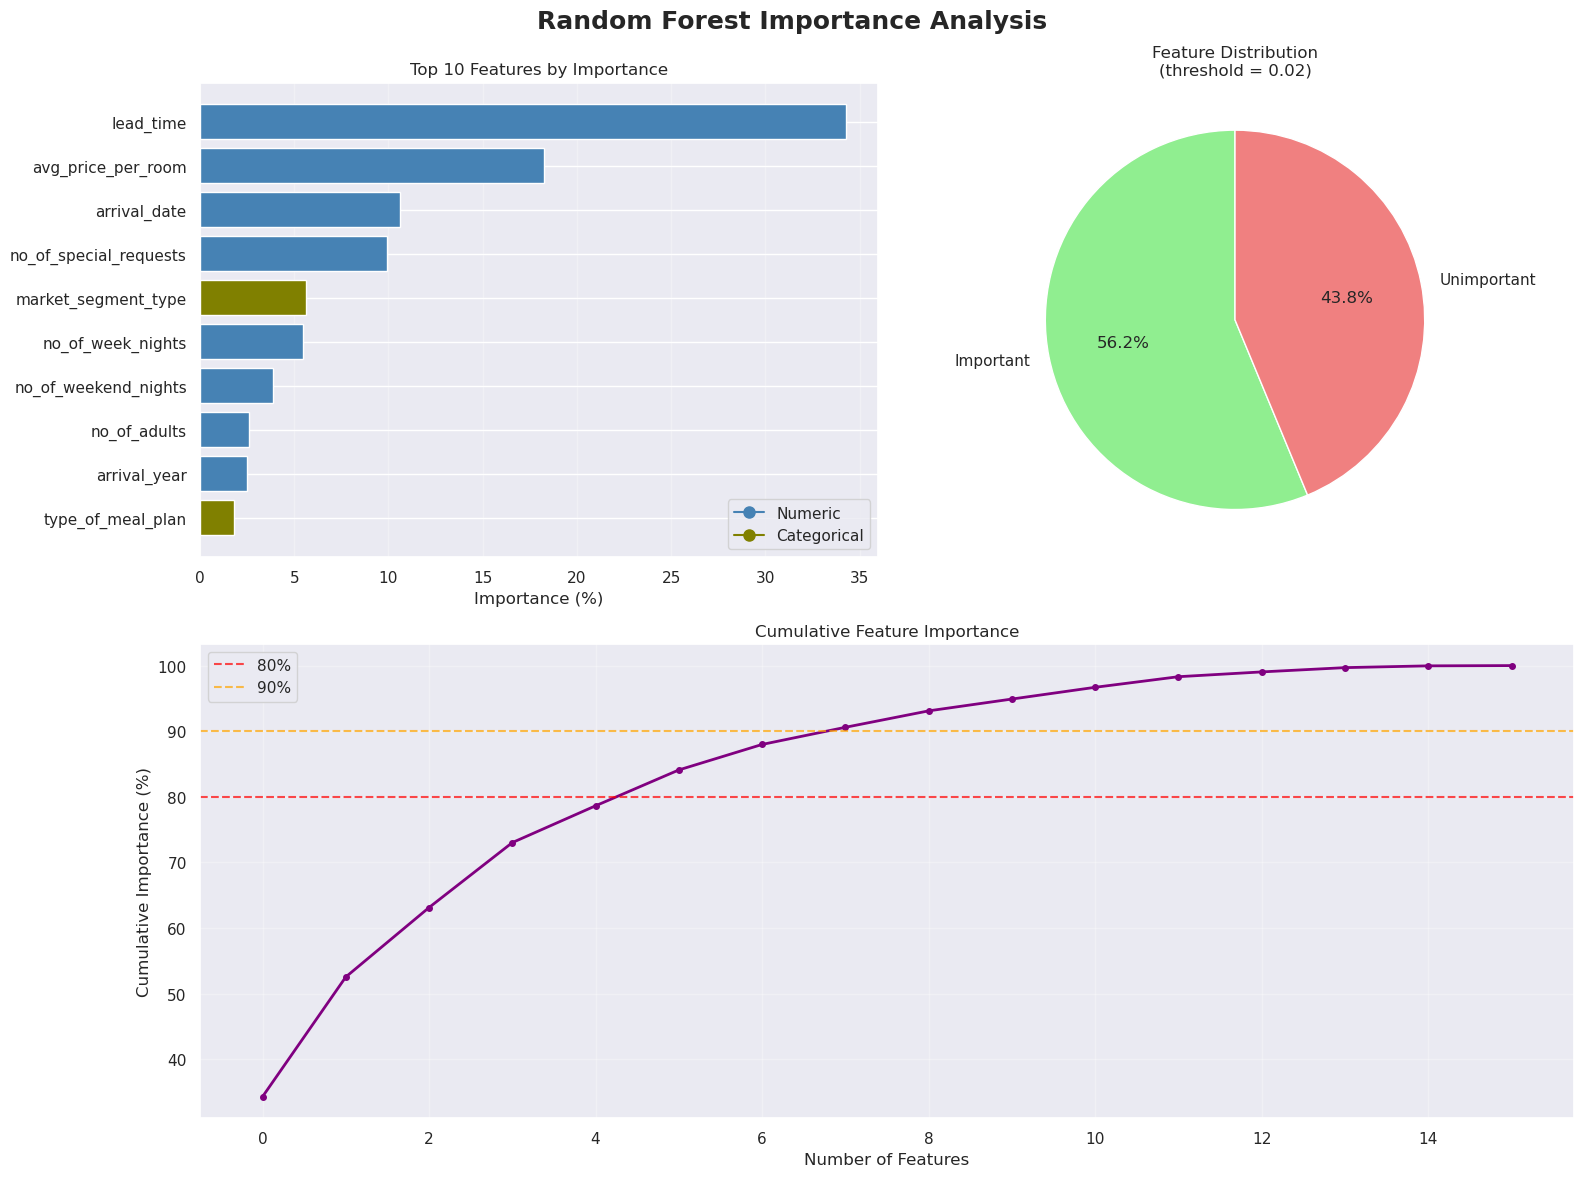

In [49]:
rf_results_importance_analysis = ImportanceAnalysis.random_forest_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    plot_results=True,
)

In [50]:
rf_results_importance_analysis

,feature,importance_score,feature_type,importance_percentage,rank,cumulative_percentage,importance_category
0,lead_time,0.342668,numeric,34.266816,1,34.266816,important
1,avg_price_per_room,0.182567,numeric,18.256666,2,52.523482,important
2,arrival_date,0.105892,numeric,10.589161,3,63.112643,important
3,no_of_special_requests,0.098999,numeric,9.899895,4,73.012538,important
4,market_segment_type,0.056098,categorical,5.609800,5,78.622338,important
5,no_of_week_nights,0.054680,numeric,5.468016,6,84.090354,important
6,no_of_weekend_nights,0.038858,numeric,3.885842,7,87.976196,important
7,no_of_adults,0.026149,numeric,2.614893,8,90.591089,important
8,arrival_year,0.025060,numeric,2.506037,9,93.097126,important
9,type_of_meal_plan,0.018022,categorical,1.802195,10,94.899321,unimportant


>**Note:**  
From *#### 🗒️ Insights for Non-Categorical Variables (Univariate)*, we identified a long-tailed distributions.
I applied the transformations and repeated the importance analysis, but the result remained the same. This is because Random Forest method is not affected by skewed features.

### permutation_importance_analysis

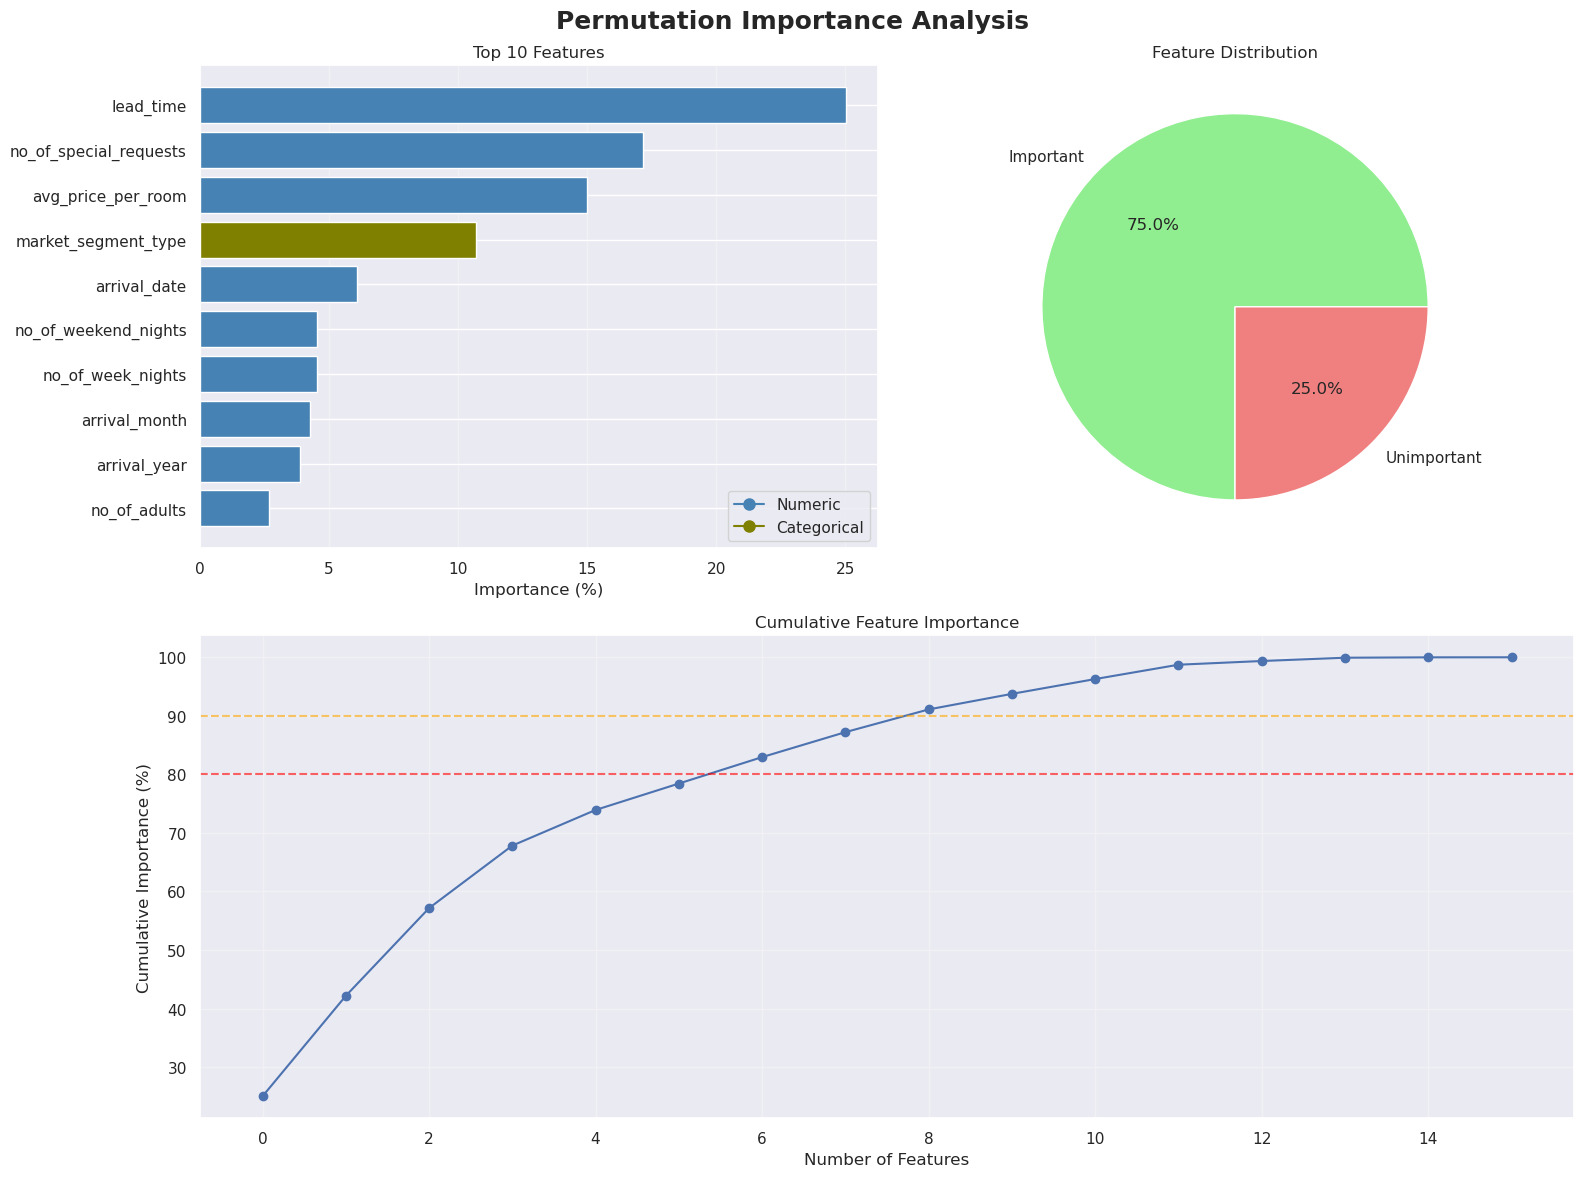

In [51]:
p_results_importance_analysis = ImportanceAnalysis.permutation_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    plot_results=True,
)

In [52]:
p_results_importance_analysis

,feature,importance_score,importance_std,feature_type,importance_percentage,rank,cumulative_percentage,importance_category
0,lead_time,0.265403,0.001380,numeric,25.017085,1,25.017085,important
1,no_of_special_requests,0.181977,0.001745,numeric,17.153236,2,42.170321,important
2,avg_price_per_room,0.159008,0.001254,numeric,14.988164,3,57.158485,important
3,market_segment_type,0.113285,0.001210,categorical,10.678287,4,67.836772,important
4,arrival_date,0.064562,0.000655,numeric,6.085693,5,73.922466,important
5,no_of_weekend_nights,0.047881,0.000759,numeric,4.513339,6,78.435805,important
6,no_of_week_nights,0.047876,0.000804,numeric,4.512820,7,82.948625,important
7,arrival_month,0.045249,0.000833,numeric,4.265182,8,87.213807,important
8,arrival_year,0.041180,0.000450,numeric,3.881643,9,91.095451,important
9,no_of_adults,0.028201,0.000520,numeric,2.658268,10,93.753719,important


### shap_importance_analysis

SHAP FEATURE IMPORTANCE ANALYSIS

[INFO] Original dataset shape: (36275, 16)
[INFO] Target distribution:
booking_status
0    24390
1    11885
Name: count, dtype: int64

[INFO] Categorical features: 3

[INFO] Training Random Forest...
[INFO] Train accuracy: 0.8826
[INFO] Test accuracy: 0.8766

[INFO] Stratified sampling: 726/7255 samples (10.0%)
[INFO] Computing SHAP values...
[SUCCESS] SHAP values computed!

[SUMMARY] Important features: 7/16
[SUMMARY] Top 5 features:
  1. lead_time: 31.28%
  2. no_of_special_requests: 22.76%
  3. market_segment_type: 14.83%
  4. avg_price_per_room: 12.02%
  5. arrival_year: 6.19%


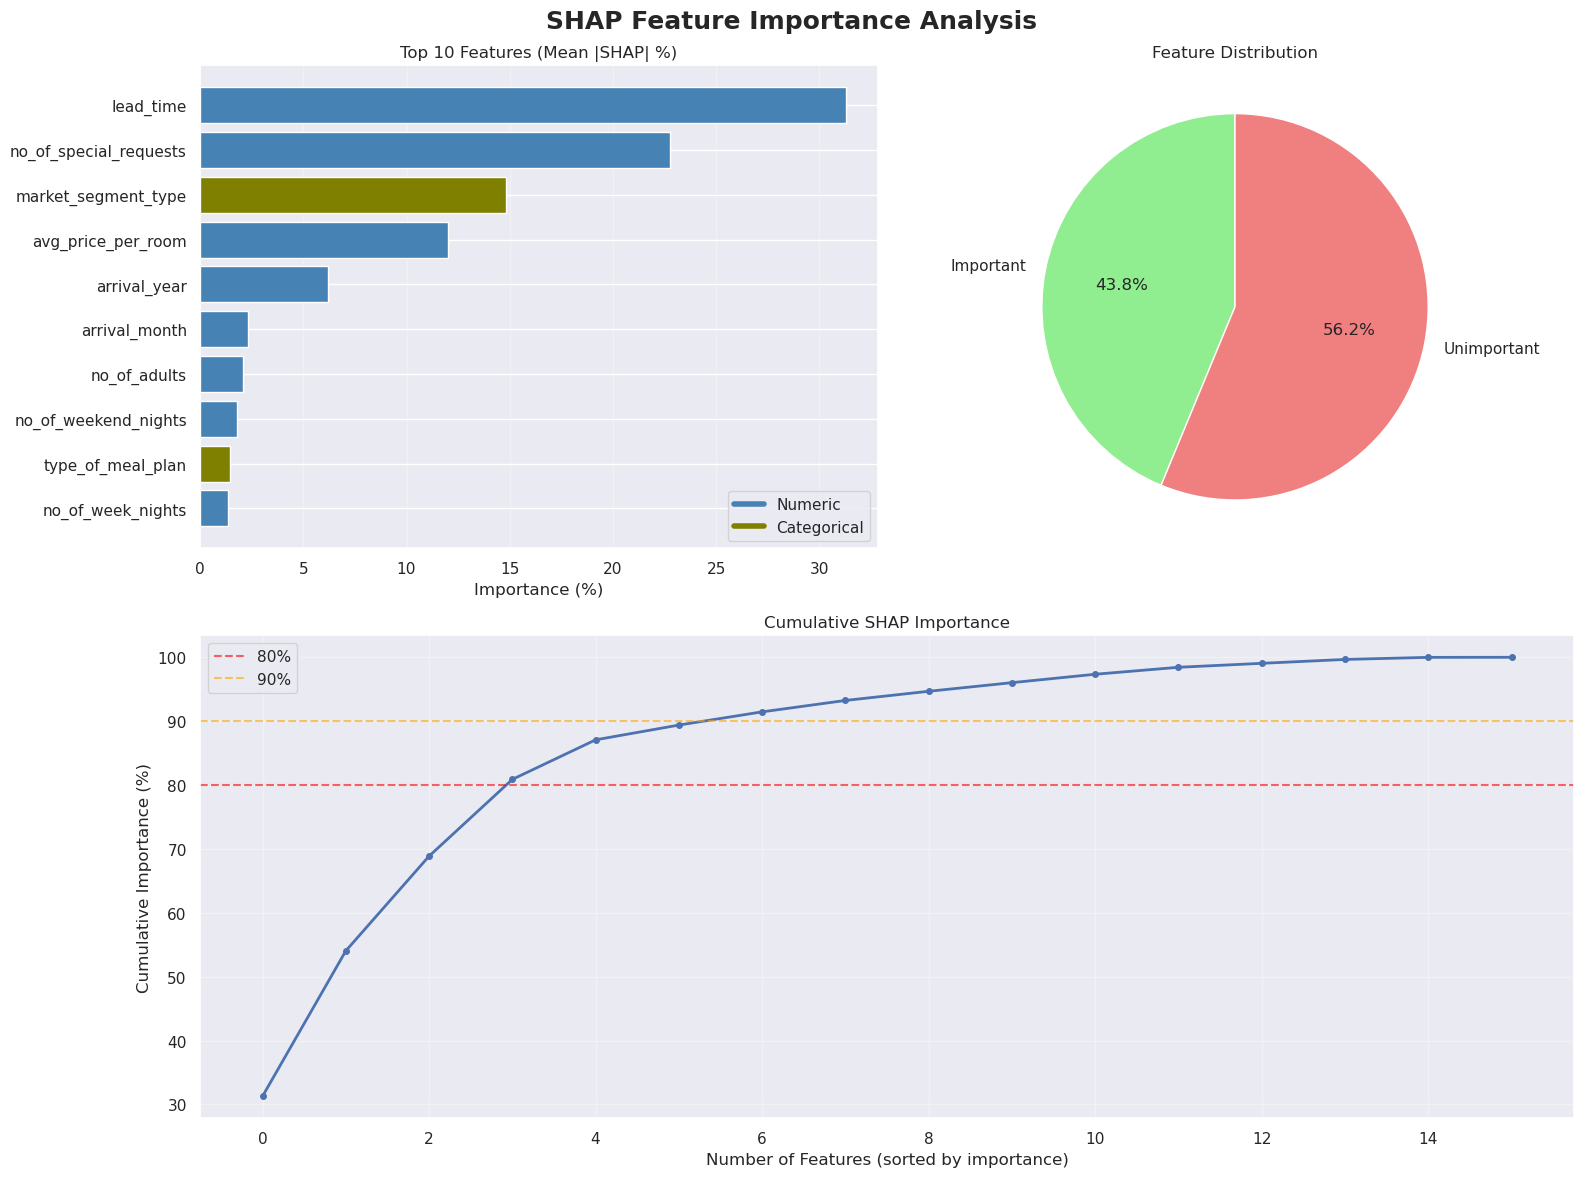


ANALYSIS COMPLETE

✅ Selected features for modeling: ['lead_time', 'no_of_special_requests', 'market_segment_type', 'avg_price_per_room', 'arrival_year', 'arrival_month', 'no_of_adults']


In [53]:
# Ejecutar análisis
shap_results_importance_analysis, _, _= ImportanceAnalysis.shap_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    pct_shap_sampling=0.1,
    test_size=0.2,
    random_state=8818,
    plot_results=True,
    figsize=(16, 12)
)

# Feature selection: obtener lista de features importantes
selected_features = shap_results_importance_analysis[
    shap_results_importance_analysis['importance_category'] == 'important'
]['feature'].tolist()

print(f"\n✅ Selected features for modeling: {selected_features}")

In [54]:
shap_results_importance_analysis

,feature,shap_importance,feature_type,importance_percentage,rank,cumulative_percentage,importance_category
0,lead_time,0.151938,numeric,31.278147,1,31.278147,important
1,no_of_special_requests,0.110566,numeric,22.761292,2,54.039439,important
2,market_segment_type,0.072036,categorical,14.829397,3,68.868836,important
3,avg_price_per_room,0.058372,numeric,12.016648,4,80.885484,important
4,arrival_year,0.030077,numeric,6.191725,5,87.077209,important
5,arrival_month,0.011227,numeric,2.311249,6,89.388458,important
6,no_of_adults,0.010045,numeric,2.067961,7,91.456419,important
7,no_of_weekend_nights,0.008678,numeric,1.786436,8,93.242855,unimportant
8,type_of_meal_plan,0.006969,categorical,1.434605,9,94.677460,unimportant
9,no_of_week_nights,0.006558,numeric,1.349961,10,96.027422,unimportant


## Feature Selection

>**From EDA analysis** the **#### 🗒️ Insights for Non Categorical - without Target**  and **## Feature Importance Analysis** conclutions we can drop:

`(arrival_date)` 
- **Modeling Insight** (*priority: low*): Very low correlation with the target; recommended to remove.
- **Business Insight**: no relevant information.

`(arrival_year)` 
- **Modeling Insight** (*priority: low*): Contains only two years (2017, 2018); may not generalize to future predictions due to potential event-specific biases.
- **Business Insight**: The limited timeframe may not be representative of future booking patterns, as specific events (e.g., a pandemic) could have skewed the results.

`(room_type_reserved)` 
- **Modeling Insight** (*priority: low*): Recommended to remove due low importance (on ### 4. Feature Importance Analysis). It had some significant association to target (Cramer's V: 0.15) (on #### 🗒️ Insights for Categorical) but is not enough.
- **Business Insight**: The type of room reserved is likely reflected in the average price per room, making the price a more direct indicator.

`(cancellations_rate)` 
- **Modeling Insight** (*priority: low*): Low correlation with the target; recommended to remove.
- **Business Insight**: no relevant information.

>**From Importance Analysis:**

- 'type_of_meal_plan' (keep for now)
- 'room_type_reserved' (*drop*) 
- 'arrival_month'  (*new drop*) 
- 'required_car_parking_space'  (*new drop*) 
- 'repeated_guest' (*drop*) 
- 'cancellations_rate (*drop*) 


> **From EDA Analysis**
> Based on the insights from **🗒️ Non-Categorical (without Target)** and **Feature Importance Analysis**, the following features are recommended for removal:

`arrival_date`

* **Modeling Insight** (*priority: low*): Very low correlation with the target → **Drop**.


`arrival_year`

* **Modeling Insight** (*priority: low*): Contains only two years (2017, 2018); limited generalization to future predictions → **Drop**.


`room_type_reserved`

* **Modeling Insight** (*priority: low*): Low importance in previous analyses (Cramer's V = 0.15 in categorical features). Association with the target is not strong enough → **Drop**.


`cancellations_rate`

* **Modeling Insight** (*priority: low*): Weak correlation with the target → **Drop**.



> **From Importance Analysis**
> Derived from all **Importance Analysis** (`importance_threshold = 0.02`), the following features were identified as having minimal predictive contribution:

`type_of_meal_plan`

* **Modeling Insight** (*priority: medium*): Slightly above the threshold; may contain minor predictive signal → **Keep for now**.


`room_type_reserved`

* **Modeling Insight** (*priority: low*): Importance score below threshold; redundant with price-related variables → **Drop**.


`arrival_month`

* **Modeling Insight** (*priority: low*): Below importance threshold; seasonality likely captured by other temporal variables → **Drop**.


`required_car_parking_space`

* **Modeling Insight** (*priority: low*): Minimal contribution to the model; low variance → **Drop**.


`repeated_guest`

* **Modeling Insight** (*priority: low*): Low importance; potential overlap with other guest-behavior variables → **Drop**.


`cancellations_rate`

* **Modeling Insight** (*priority: low*): Below threshold and redundant with other booking-related variables → **Drop**.


In [55]:
df.drop(columns=["room_type_reserved","arrival_year","repeated_guest",
                 "arrival_date", "arrival_month", "cancellations_rate", "arrival_month", "required_car_parking_space"],inplace=True)

> I will repeate the importance analysis to check the new summy columns

### shap_results_importance_analysis again without the last droped features

SHAP FEATURE IMPORTANCE ANALYSIS

[INFO] Original dataset shape: (36275, 9)
[INFO] Target distribution:
booking_status
0    24390
1    11885
Name: count, dtype: int64

[INFO] Categorical features: 2

[INFO] Training Random Forest...
[INFO] Train accuracy: 0.8784
[INFO] Test accuracy: 0.8695

[INFO] Stratified sampling: 3628/7255 samples (50.0%)
[INFO] Computing SHAP values...
[SUCCESS] SHAP values computed!

[SUMMARY] Important features: 6/9
[SUMMARY] Top 5 features:
  1. lead_time: 32.55%
  2. no_of_special_requests: 25.80%
  3. market_segment_type: 17.46%
  4. avg_price_per_room: 14.78%
  5. no_of_adults: 2.75%


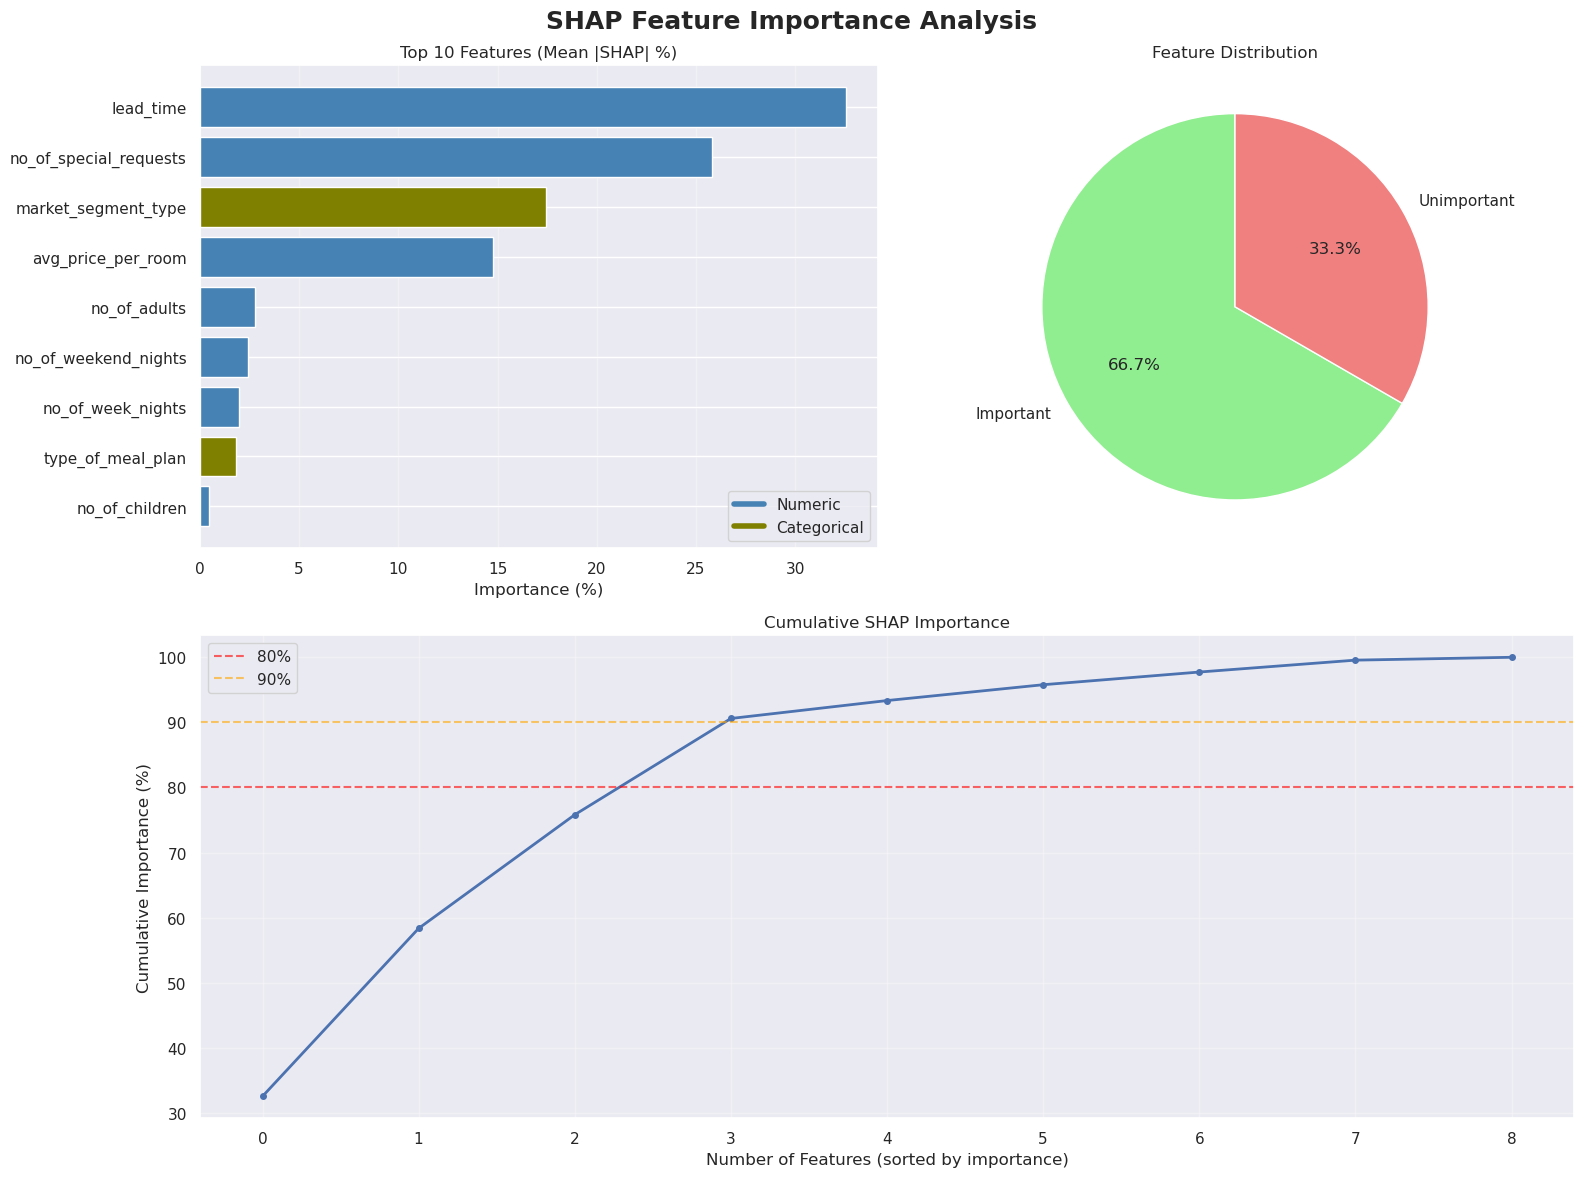


ANALYSIS COMPLETE


In [56]:
shap_results_importance_analysis, _, _= ImportanceAnalysis.shap_importance_analysis(
    df=df,
    target='booking_status',
    importance_threshold=0.02,
    top_n=10,
    pct_shap_sampling=0.5,
    test_size=0.2,
    random_state=8818,
    plot_results=True,
    figsize=(16, 12)
)

In [57]:
shap_results_importance_analysis

,feature,shap_importance,feature_type,importance_percentage,rank,cumulative_percentage,importance_category
0,lead_time,0.157234,numeric,32.552041,1,32.552041,important
1,no_of_special_requests,0.124621,numeric,25.800312,2,58.352353,important
2,market_segment_type,0.084347,categorical,17.462392,3,75.814745,important
3,avg_price_per_room,0.071410,numeric,14.784003,4,90.598748,important
4,no_of_adults,0.013295,numeric,2.752555,5,93.351303,important
5,no_of_weekend_nights,0.011751,numeric,2.432766,6,95.784069,important
6,no_of_week_nights,0.009413,numeric,1.948692,7,97.732761,unimportant
7,type_of_meal_plan,0.008831,categorical,1.828229,8,99.560991,unimportant
8,no_of_children,0.002121,numeric,0.439009,9,100.000000,unimportant


In [58]:
less_important_features = shap_results_importance_analysis[shap_results_importance_analysis['importance_category']=='unimportant'].sort_values(by='shap_importance', ascending=False)
less_important_features['feature'].to_list()

['no_of_week_nights', 'type_of_meal_plan', 'no_of_children']

## Determine x and y

In [59]:
X = df.drop(columns="booking_status")
y = df.booking_status

## Train-Test Split

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8818, stratify=y
)

print("Data successfully split.")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data successfully split.
X_train: (29020, 9)
X_test: (7255, 9)
y_train: (29020,)
y_test: (7255,)


## Preprocessing Pipeline
Objective: Centralize all preprocessing steps (scaling, encoding, rare-category grouping, and automatic second part of feature selection on categorical onehot encoding with poor frecuency), to ensure consistency, reproducibility, and prevention of data leakage.

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import joblib

### Rare Category Grouping (optional pre-step)

 **Note** 
 In *### Rare Category Grouping (optional pre-step)* and *### Remove grouped rare categories* is added because i need to quit future categorical encodes with low frequency before onehot encoding. 
 This is because the use of pipelines has integrated onehot oncoding to you cant quit rare frecuency features at that point.

In [62]:
# #TODO maybe implement in order to quit before onehot encoding. this is because the use of pipelines has integrated onehot oncoding to you cant quit rare frecuency features at that point

### Remove grouped rare categories  (optional pre-step)

In [63]:
#TODO implement in order to quit before onehot encoding. this is because the use of pipelines has integrated onehot oncoding to you cant quit rare frecuency features at that point

### ColumnTransformer (scaler + OneHotEncoder + PCA)

In [64]:
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in categorical_cols]

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numeric columns: {len(numeric_cols)}")

Categorical columns: 2
Numeric columns: 7


In [65]:
# === Define subgroups for manual PCA ===
pca_people_cols = ["no_of_adults", "no_of_children"]
pca_week_cols = ["no_of_weekend_nights", "no_of_week_nights"]

# Ensure these columns exist in the dataset (prevents errors)
pca_people_cols = [c for c in pca_people_cols if c in X_train.columns]
pca_week_cols = [c for c in pca_week_cols if c in X_train.columns]

# Remaining numeric columns that are not part of the PCA groups
other_numeric_cols = [c for c in numeric_cols if c not in pca_people_cols + pca_week_cols]

print("PCA subgroups defined successfully")

PCA subgroups defined successfully


In [66]:
# === Define transformers for preprocessing ===
# Numeric transformation for the remaining numeric features
other_numeric_transformer = RobustScaler()

# Custom transformers for the PCA groups
pca_people_transformer = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=1, random_state=8818))
])

pca_week_transformer = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=1, random_state=8818))
])

# Categorical transformation
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore", 
    sparse_output=False
)

### Model Pipeline (preprocessor)

In [67]:
# === Combine all transformers ===
# Each transformer applies only to its designated subset of columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", other_numeric_transformer, other_numeric_cols),
        ("pca_people", pca_people_transformer, pca_people_cols),
        ("pca_week", pca_week_transformer, pca_week_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"  # Drop unlisted columns
)

print("Preprocessor configured successfully")

Preprocessor configured successfully


## Main Metrics Used

**Main Metrics**

**1. Precision** *(from classification_report)*

Measures how many of the positive predictions were actually positive.  
**Formula:** `Precision = TP / (TP + FP)`  
“When I predict something as positive, how often am I correct?”  
**Use Case:** Use when **false positives are costly**.  
*Example:* In email spam detection, you don’t want to mark important emails as spam.

**2. Recall / Sensitivity / True Positive Rate (TPR)** *(from classification_report)*

Measures the proportion of actual positive cases that were correctly detected.  
**Formula:** `Recall = TP / (TP + FN)`  
“Out of all actual positives, how many did I find?”  
**Use Case:** Use when **missing positive cases is costly**.  
*Example:* In disease screening, you want to catch as many sick patients as possible, even if it means more false alarms.

**3. Specificity / True Negative Rate (TNR)**

Measures the proportion of actual negative cases that were correctly identified as negative.  
**Formula:** `Specificity = TN / (TN + FP)`  
“Out of all actual negatives, how many did I correctly identify as negative?”  
**Use Case:** Use when **correctly identifying negatives is important**.  
*Example:* In fraud detection, you want to avoid flagging normal transactions as fraudulent.  

**4. F1-score** *(from classification_report)*

Harmonic mean between **precision** and **recall**, useful when classes are imbalanced.  
**Formula:** `F1 = 2 * (Precision * Recall) / (Precision + Recall)`  
“Balances between avoiding false positives and false negatives.”  
**Use Case:** Use when you need a **balance between precision and recall**, especially with imbalanced classes.  
*Example:* In predicting rare equipment failures, you want to detect failures but also avoid too many false alarms.  

**5. Accuracy** *(from classification_report)*

Total proportion of correct predictions (positive and negative).  
**Formula:** `Accuracy = (TP + TN) / (TP + TN + FP + FN)`  
“Out of all predictions, how many did I get right?”  
**Use Case:** Use when **classes are balanced** and false positives/negatives have similar costs.  
*Example:* In image recognition of common objects, where each class is roughly equally represented.  

**6. Support** *(from classification_report)*

Number of true samples of each class in the test set.  
**Not a performance metric**, it just indicates the size of each class.  
**Use Case:** Use to **understand class distribution** and evaluate whether metrics like precision or recall are meaningful.  
*Example:* If one class has very few samples, metrics like accuracy might be misleading.  

---

| Metric | Formula | Use Case | Example |
|--------|---------|----------|---------|
| Precision *(from classification_report)* | `TP / (TP + FP)` | When **false positives are costly** | In email spam detection, you don’t want to mark important emails as spam |
| Recall / Sensitivity / TPR *(from classification_report)* | `TP / (TP + FN)` | When **missing positive cases is costly** | In disease screening, you want to catch as many sick patients as possible, even if it means more false alarms |
| Specificity / TNR | `TN / (TN + FP)` | When **correctly identifying negatives is important** | In fraud detection, avoid flagging normal transactions as fraudulent |
| F1-score *(from classification_report)* | `2 * (Precision * Recall) / (Precision + Recall)` | When you need a **balance between precision and recall**, especially with imbalanced classes | Predicting rare equipment failures, you want to detect failures but avoid too many false alarms |
| Accuracy *(from classification_report)* | `(TP + TN) / (TP + TN + FP + FN)` | When **classes are balanced** and false positives/negatives have similar costs | Image recognition of common objects where each class is roughly equally represented |
| Support *(from classification_report)* | Count of true samples per class | To **understand class distribution** and check if metrics are meaningful | If one class has very few samples, accuracy may be misleading |


**Enhanced Key Metrics for the Hotel Reservation Prediction Project**

To evaluate the cancellation prediction model, we will prioritize the following metrics:

- **Recall (Class 1 - Cancellations)**: Essential for detecting the majority of actual cancellations, enabling proactive retention actions and minimizing revenue loss from unexpected no-shows.

- **Precision (Class 1)**: Critical for minimizing false alarms and avoiding unnecessary costs from retention campaigns targeting guests who would have honored their reservations.

- **Specificity (Class 0 - Non-Cancellations)**: Important for correctly identifying loyal guests who will honor their reservations, ensuring we maintain positive customer relationships and optimize room allocation strategies.

- **False Positive Rate (FPR)**: Measures the proportion of loyal customers incorrectly flagged as potential cancellations. Critical for controlling customer experience damage and avoiding unnecessary retention costs.

In [68]:
# I will reuse this funtion in all the project

def print_confusion_matrix_analysis(y_test, y_pred):
    """
    Analyze and display confusion matrix metrics with business interpretation
    for hotel cancellation prediction only.
    
    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate all key business metrics
    specificity = tn / (tn + fp)  
    recall = tp / (tp + fn)       
    precision = tp / (tp + fp)
    false_positive_rate = fp / (fp + tn)
    
    print("\n===== CONFUSION MATRIX METRICS =====")
    print(f"True Negatives (TN): {tn} - Correct non-cancellation predictions")
    print(f"False Positives (FP): {fp} - False alarms (predicted cancel, but didn't)")
    print(f"False Negatives (FN): {fn} - Missed cancellations") 
    print(f"True Positives (TP): {tp} - Correctly predicted cancellations")
    
    print(f"\n===== KEY BUSINESS METRICS =========")
    print(f"Recall (Class 1): {recall:.2%} - Actual cancellations detected")
    print(f"Precision (Class 1): {precision:.2%} - Prediction accuracy for cancellations")
    print(f"Specificity (Class 0): {specificity:.2%} - Loyal customers correctly identified")
    print(f"False Positive Rate: {false_positive_rate:.2%} - Loyal customers mistakenly flagged")

## Modeling With Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=8818,
        n_jobs=-1,
        #class_weight='balanced' # we will work on it manually
    ))
])

# Train model
rf_pipeline.fit(X_train, y_train)
print("Random Forest model trained successfully")
print("Accuracy : % {}".format(rf_pipeline.score(X_test,y_test)*100))

# Define Prediction acording the new model+pipeline
y_pred = rf_pipeline.predict(X_test)

Random Forest model trained successfully
Accuracy : % 88.28394210889043


In [70]:
# This metrics gives me more information
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4878
           1       0.84      0.79      0.82      2377

    accuracy                           0.88      7255
   macro avg       0.87      0.86      0.86      7255
weighted avg       0.88      0.88      0.88      7255



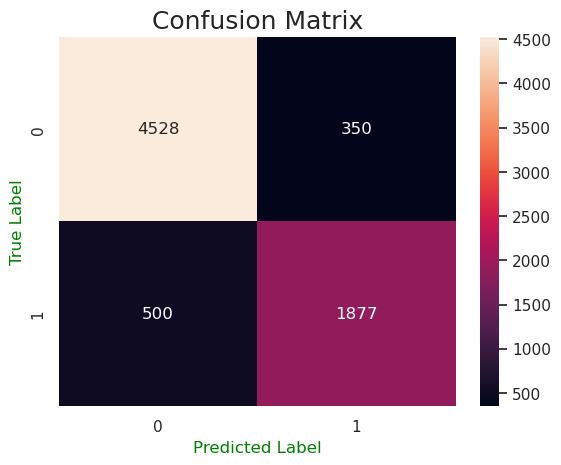


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4528 - Correct non-cancellation predictions
False Positives (FP): 350 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 500 - Missed cancellations
True Positives (TP): 1877 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 78.97% - Actual cancellations detected
Precision (Class 1): 84.28% - Prediction accuracy for cancellations
Specificity (Class 0): 92.82% - Loyal customers correctly identified
False Positive Rate: 7.18% - Loyal customers mistakenly flagged


In [71]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12);
plt.show()

print_confusion_matrix_analysis(y_test, y_pred)

### Inferences
* As we see we have good accuracy.
* But when we check the other metrics we see that even though we predict not cancelled class so good (specificity) , we are not so good at predicting cancelled class (sensitivity/recall).
* This is based on imbalanced dataset as i mentioned i think we need to get rid of this problem.
* First i will use **undersampling** method after that i will use **oversampling**.
* Finally i will compare the results.

## Under-Sampling & Over-Sampling Methods

### Addressing Class Imbalance

**The Problem**: Our dataset shows significant class imbalance with approximately 32.8% cancellations vs 67.2% non-cancellations. This imbalance can lead to models that are biased toward the majority class, achieving high accuracy but poor performance on the minority class we care about (cancellations).

### Sampling Strategies Implemented

#### 🔻 Under-Sampling (RandomUnderSampler)
- **Method**: Reduces the majority class by randomly removing samples until balanced
- **Mechanism**: Keeps all minority class samples and randomly subsets majority class
- **Advantage**: Reduces training time, helps models focus on decision boundary
- **Risk**: Potential loss of important majority class information
- **Our Implementation**: Integrated directly into training pipeline

#### 🔺 Over-Sampling (SVMSMOTE)
- **Method**: Increases the minority class by generating synthetic samples
- **Mechanism**: Uses Support Vector Machines to create new minority samples near class boundaries
- **Advantage**: Preserves all original data, can improve minority class detection
- **Risk**: Potential overfitting if synthetic samples are too similar
- **Our Implementation**: Integrated directly into training pipeline

### Pipeline Integration Strategy

**Why Inside Pipelines?**
- **Data Leakage Prevention**: Sampling applied only during training, not testing
- **Reproducibility**: Entire preprocessing + sampling + modeling chain in one object
- **Deployment Ready**: Easy model export and consistent behavior in production
- **Automated Re-training**: Simplified model updates with consistent sampling

**Technical Implementation:**
```python
from imblearn.pipeline import Pipeline as ImbPipeline

# Both sampling methods integrated into unified pipelines
pipeline_under = ImbPipeline([
    ('preprocessor', preprocessor),           # Scaling + Encoding
    ('sampler', RandomUnderSampler()),        # Under-sampling
    ('model', RandomForestClassifier())       # Classifier
])

pipeline_over = ImbPipeline([
    ('preprocessor', preprocessor),           # Scaling + Encoding  
    ('sampler', SVMSMOTE()),                  # Over-sampling
    ('model', RandomForestClassifier())       # Classifier
])
```

In [72]:
def print_sampling_comparison_chart(X_train, y_train, random_state=8818):
    """
    Shows a visual comparison of class distributions after applying
    under-sampling and over-sampling for educational purposes, without requiring preprocessing.

    Parameters:
    X_train (pd.DataFrame): Training features
    y_train (pd.Series): Training target  
    random_state (int): Seed for reproducibility
    """
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import RandomOverSampler

    print("=" * 80)
    print("📊 CLASS DISTRIBUTION COMPARISON (FOR ANALYSIS ONLY)")
    print("=" * 80)

    # Under-sampling
    under_sampler = RandomUnderSampler(random_state=random_state)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train) # type: ignore

    # Over-sampling
    over_sampler = RandomOverSampler(random_state=random_state)
    X_over, y_over = over_sampler.fit_resample(X_train, y_train) # type: ignore

    # Calculate percentages and totals
    orig_counts = y_train.value_counts().sort_index()
    under_counts = y_under.value_counts().sort_index()
    over_counts = y_over.value_counts().sort_index()

    orig_total = len(y_train)
    under_total = len(y_under)
    over_total = len(y_over)

    orig_pct0 = (orig_counts[0] / orig_total) * 100
    orig_pct1 = (orig_counts[1] / orig_total) * 100


    # Original Dataset
    print(f"\n📊 ORIGINAL DATASET ({orig_total:,} total records):")
    bar0 = "▓" * int(orig_pct0 / 2)
    bar1 = "░" * int(orig_pct1 / 2)
    print(f"Not Canceled (0): {bar0} {orig_counts[0]:,} ({orig_pct0:.1f}%)")
    print(f"Canceled (1):     {bar1} {orig_counts[1]:,} ({orig_pct1:.1f}%)")

    # Under-sampling Results
    print(f"\n🔻 UNDER-SAMPLING RESULTS ({under_total:,} total records):")
    bar_under0 = "▓" * 25
    bar_under1 = "░" * 25
    print(f"Not Canceled (0): {bar_under0} {under_counts[0]:,} (50.0%)")
    print(f"Canceled (1):     {bar_under1} {under_counts[1]:,} (50.0%)")

    # Over-sampling Results  
    print(f"\n🔺 OVER-SAMPLING RESULTS ({over_total:,} total records):")
    bar_over0 = "▓" * 25
    bar_over1 = "░" * 25
    print(f"Not Canceled (0): {bar_over0} {over_counts[0]:,} (50.0%)")
    print(f"Canceled (1):     {bar_over1} {over_counts[1]:,} (50.0%)")

    # Dataset size comparison
    print(f"\n📈 DATASET SIZE COMPARISON:")
    print(f"Original:  {orig_total:,} records")
    print(f"Under:     {under_total:,} records ({under_total-orig_total:+,} change)")
    print(f"Over:      {over_total:,} records ({over_total-orig_total:+,} change)")

    print("\n" + "=" * 80)
    print("LEGEND: ▓ = Not Canceled (Class 0)  ░ = Canceled (Class 1)")
    print("NOTE: This is for visualization only - actual sampling happens in pipelines")
    print("=" * 80)

In [73]:
print_sampling_comparison_chart(X_train, y_train)

📊 CLASS DISTRIBUTION COMPARISON (FOR ANALYSIS ONLY)

📊 ORIGINAL DATASET (29,020 total records):
Not Canceled (0): ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 19,512 (67.2%)
Canceled (1):     ░░░░░░░░░░░░░░░░ 9,508 (32.8%)

🔻 UNDER-SAMPLING RESULTS (19,016 total records):
Not Canceled (0): ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 9,508 (50.0%)
Canceled (1):     ░░░░░░░░░░░░░░░░░░░░░░░░░ 9,508 (50.0%)

🔺 OVER-SAMPLING RESULTS (39,024 total records):
Not Canceled (0): ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 19,512 (50.0%)
Canceled (1):     ░░░░░░░░░░░░░░░░░░░░░░░░░ 19,512 (50.0%)

📈 DATASET SIZE COMPARISON:
Original:  29,020 records
Under:     19,016 records (-10,004 change)
Over:      39,024 records (+10,004 change)

LEGEND: ▓ = Not Canceled (Class 0)  ░ = Canceled (Class 1)
NOTE: This is for visualization only - actual sampling happens in pipelines


## Modeling With Under-Sampling

### Random Forest

In [74]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Pipeline unificado para under-sampling
rf_pipeline_under = ImbPipeline([
    ("preprocessor", preprocessor),              # Scaling + OHE
    ("undersampler", RandomUnderSampler(random_state=8818)),  # Under-sampling
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=8818,
        n_jobs=-1
    ))
])

# Entrenar con datos originales
rf_pipeline_under.fit(X_train, y_train)
print("Random Forest trained with under-sampling pipeline")

# Define Prediction acording the new model+pipeline
y_pred = rf_pipeline_under.predict(X_test)

Random Forest trained with under-sampling pipeline


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4878
           1       0.75      0.86      0.80      2377

    accuracy                           0.86      7255
   macro avg       0.84      0.86      0.85      7255
weighted avg       0.87      0.86      0.86      7255



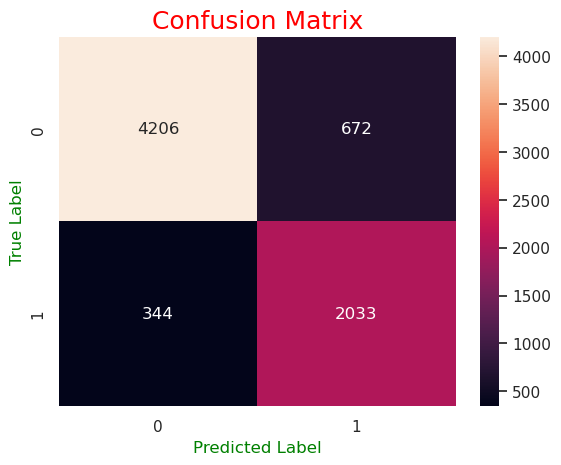


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4206 - Correct non-cancellation predictions
False Positives (FP): 672 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 344 - Missed cancellations
True Positives (TP): 2033 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 85.53% - Actual cancellations detected
Precision (Class 1): 75.16% - Prediction accuracy for cancellations
Specificity (Class 0): 86.22% - Loyal customers correctly identified
False Positive Rate: 13.78% - Loyal customers mistakenly flagged


In [76]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

#### Inferences
* Although the specificity score decreases it seems that we solved the problem.
* Our accuracy has decreased but we predict both classes well and i think this one is more accurate.
* Because for the model before the sampling, if we have a dataset that is generated with mostly the canceled samples to predict the model will not be able to predict them accurately.
* Now lets try some other algorithms...

### XGB

In [77]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# XGBoost Pipeline with Integrated Under-Sampling
xgb_pipeline_under = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=8818)),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,           # Controls overfitting
        learning_rate=0.1,     # Learning rate
        subsample=0.8,         # Prevents overfitting
        colsample_bytree=0.8,  # Prevents overfitting
        random_state=8818,
        n_jobs=-1,
        eval_metric='logloss'
    ))
])

# Train on ORIGINAL data (under-sampling happens automatically in pipeline)
xgb_pipeline_under.fit(X_train, y_train)
print("XGBoost trained with integrated under-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_under = xgb_pipeline_under.predict(X_test)

XGBoost trained with integrated under-sampling pipeline


In [78]:
print(classification_report(y_test,xgb_pipeline_under.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4878
           1       0.76      0.84      0.79      2377

    accuracy                           0.86      7255
   macro avg       0.84      0.85      0.84      7255
weighted avg       0.86      0.86      0.86      7255



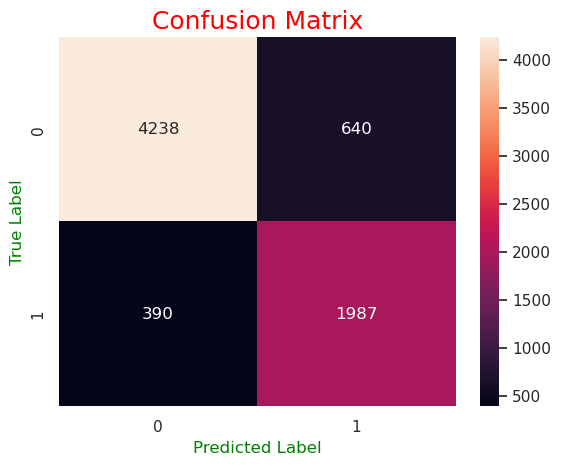


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4238 - Correct non-cancellation predictions
False Positives (FP): 640 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 390 - Missed cancellations
True Positives (TP): 1987 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 83.59% - Actual cancellations detected
Precision (Class 1): 75.64% - Prediction accuracy for cancellations
Specificity (Class 0): 86.88% - Loyal customers correctly identified
False Positive Rate: 13.12% - Loyal customers mistakenly flagged


In [79]:
y_pred = y_pred_under
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

### Logistic Regression

In [80]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

# Logistic Regression Pipeline with Integrated Under-Sampling
logreg_pipeline_under = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=8818)),
    ("model", LogisticRegression(
        random_state=8818,
        max_iter=1000,  # Important for convergence
        n_jobs=-1       # Parallelization if there's lots of data
    ))
])

# Train on ORIGINAL data (under-sampling happens automatically in pipeline)
logreg_pipeline_under.fit(X_train, y_train)
print("Logistic Regression trained with integrated under-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_under = logreg_pipeline_under.predict(X_test)

Logistic Regression trained with integrated under-sampling pipeline


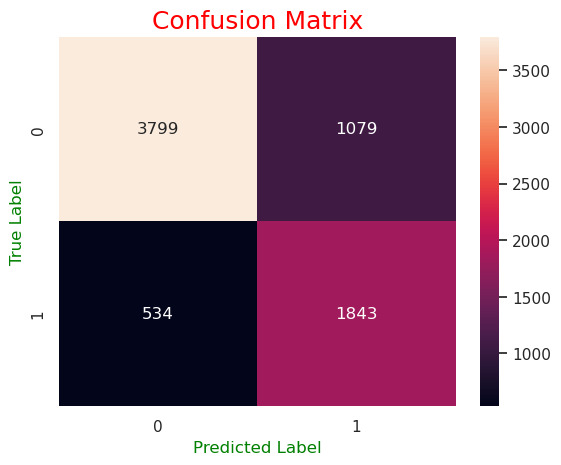


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 3799 - Correct non-cancellation predictions
False Positives (FP): 1079 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 534 - Missed cancellations
True Positives (TP): 1843 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 77.53% - Actual cancellations detected
Precision (Class 1): 63.07% - Prediction accuracy for cancellations
Specificity (Class 0): 77.88% - Loyal customers correctly identified
False Positive Rate: 22.12% - Loyal customers mistakenly flagged


In [81]:
y_pred = y_pred_under
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

👎 Lower performance, the model is not going to be tested on over-sampled data

### SVC (Support Vector Classifier)

In [82]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

# SVC Pipeline with Integrated Under-Sampling
svc_pipeline_under = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=8818)),
    ("model", SVC(
        random_state=8818,
        probability=True  # Important if you want to use predict_proba
    ))
])

# Train on ORIGINAL data (under-sampling happens automatically in pipeline)
svc_pipeline_under.fit(X_train, y_train)
print("SVC trained with integrated under-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_under = svc_pipeline_under.predict(X_test)

SVC trained with integrated under-sampling pipeline


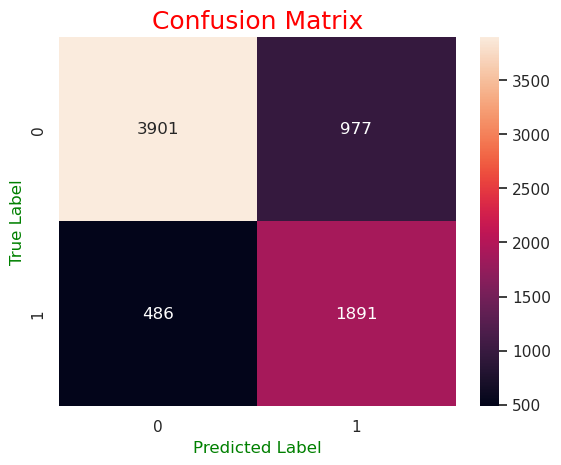


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 3901 - Correct non-cancellation predictions
False Positives (FP): 977 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 486 - Missed cancellations
True Positives (TP): 1891 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 79.55% - Actual cancellations detected
Precision (Class 1): 65.93% - Prediction accuracy for cancellations
Specificity (Class 0): 79.97% - Loyal customers correctly identified
False Positive Rate: 20.03% - Loyal customers mistakenly flagged


In [83]:
y_pred = y_pred_under
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

👎 Lower performance, the model is not going to be tested on over-sampled data

### CatBoost Classifier

In [84]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier

# CatBoost Pipeline with Integrated Under-Sampling
catboost_pipeline_under = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=8818)),
    ("model", CatBoostClassifier(
        random_state=8818,
        verbose=100, 
        thread_count=-1,
        allow_writing_files=False 
    ))
])

# Train on ORIGINAL data (under-sampling happens automatically in pipeline)
catboost_pipeline_under.fit(X_train, y_train)
print("CatBoost trained with integrated under-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_under = catboost_pipeline_under.predict(X_test)

Learning rate set to 0.036234
0:	learn: 0.6708342	total: 49ms	remaining: 49s
100:	learn: 0.3982642	total: 282ms	remaining: 2.51s
200:	learn: 0.3714901	total: 519ms	remaining: 2.06s
300:	learn: 0.3540446	total: 742ms	remaining: 1.72s
400:	learn: 0.3386844	total: 973ms	remaining: 1.45s
500:	learn: 0.3283640	total: 1.2s	remaining: 1.19s
600:	learn: 0.3196039	total: 1.43s	remaining: 950ms
700:	learn: 0.3117805	total: 1.66s	remaining: 710ms
800:	learn: 0.3045113	total: 1.89s	remaining: 469ms
900:	learn: 0.2982441	total: 2.12s	remaining: 233ms
999:	learn: 0.2927927	total: 2.34s	remaining: 0us
CatBoost trained with integrated under-sampling pipeline


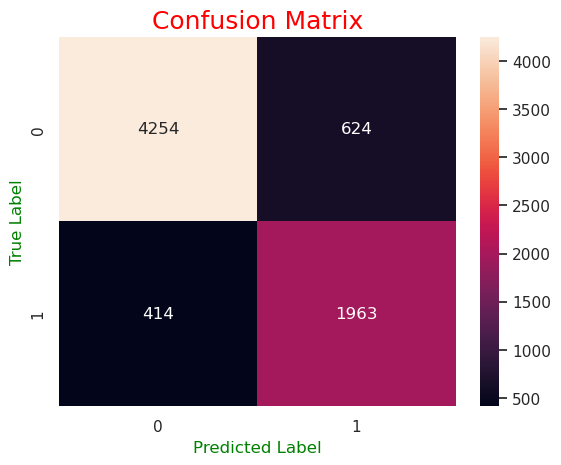


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4254 - Correct non-cancellation predictions
False Positives (FP): 624 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 414 - Missed cancellations
True Positives (TP): 1963 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 82.58% - Actual cancellations detected
Precision (Class 1): 75.88% - Prediction accuracy for cancellations
Specificity (Class 0): 87.21% - Loyal customers correctly identified
False Positive Rate: 12.79% - Loyal customers mistakenly flagged


In [85]:
y_pred = y_pred_under
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

### Inferences After Tried The Algorithms
* I tried some algorithms on this dataset and 3 of them worked well.
* These are Random Forest, XGBoost and CatBoost.
* In order to get better results i will benefit from these 3 algorithms by using ensemble learning with Voting Classifier.
* I hope i will get better results...

### Voting Classifier

>💡
**What is Voting Classifier**  
A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
> 

In [86]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier

# Voting Classifier Pipeline with Integrated Under-Sampling
voting_pipeline_under = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=8818)),
    ("model", VotingClassifier(
        estimators=[
            ("xgb", XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=8818,
                n_jobs=-1,
                eval_metric='logloss'
            )),
            ("rf", RandomForestClassifier(
                n_estimators=200,
                random_state=8818,
                n_jobs=-1
            )),
            ("cat", CatBoostClassifier(
                random_state=8818,
                verbose=100,
                thread_count=-1,
                allow_writing_files=False
            )) # type: ignore
        ],
        voting="soft",
        weights=[1, 2.5, 1.5]
    ))
])

# Train on ORIGINAL data (under-sampling happens automatically in pipeline)
voting_pipeline_under.fit(X_train, y_train)
print("Voting Classifier trained with integrated under-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_under = voting_pipeline_under.predict(X_test)

Learning rate set to 0.036234
0:	learn: 0.6708342	total: 2.85ms	remaining: 2.85s
100:	learn: 0.3982642	total: 232ms	remaining: 2.07s
200:	learn: 0.3714901	total: 463ms	remaining: 1.84s
300:	learn: 0.3540446	total: 697ms	remaining: 1.62s
400:	learn: 0.3386844	total: 930ms	remaining: 1.39s
500:	learn: 0.3283640	total: 1.16s	remaining: 1.16s
600:	learn: 0.3196039	total: 1.39s	remaining: 922ms
700:	learn: 0.3117805	total: 1.61s	remaining: 689ms
800:	learn: 0.3045113	total: 1.84s	remaining: 458ms
900:	learn: 0.2982441	total: 2.07s	remaining: 227ms
999:	learn: 0.2927927	total: 2.29s	remaining: 0us
Voting Classifier trained with integrated under-sampling pipeline


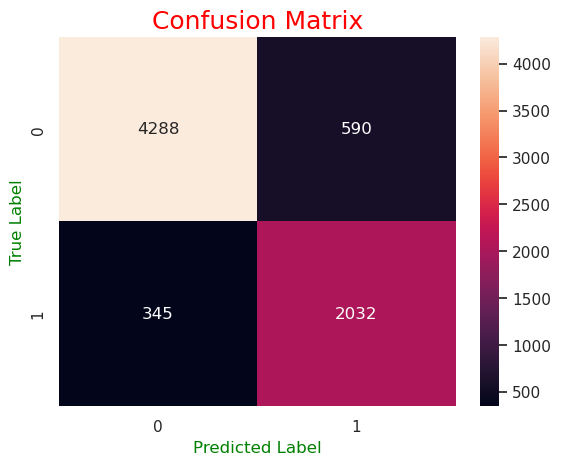


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4288 - Correct non-cancellation predictions
False Positives (FP): 590 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 345 - Missed cancellations
True Positives (TP): 2032 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 85.49% - Actual cancellations detected
Precision (Class 1): 77.50% - Prediction accuracy for cancellations
Specificity (Class 0): 87.90% - Loyal customers correctly identified
False Positive Rate: 12.10% - Loyal customers mistakenly flagged


In [87]:
y_pred = y_pred_under
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

## Modeling With Over-sampling (SVM-SMOTE)


In [88]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SVMSMOTE

# Crear un pipeline que incluya preprocesamiento + SMOTE + modelo
rf_pipeline_over_smote = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SVMSMOTE(random_state=8818)),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=8818,
        n_jobs=-1
    ))
])

# Entrenar directamente con los datos originales
rf_pipeline_over_smote.fit(X_train, y_train)
print("Pipeline con SMOTE entrenado exitosamente")

# Predecir
y_pred = rf_pipeline_over_smote.predict(X_test)

Pipeline con SMOTE entrenado exitosamente


### Random Forest

In [89]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SVMSMOTE
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline with Integrated Over-Sampling
rf_pipeline_over = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SVMSMOTE(random_state=8818)),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=8818,
        n_jobs=-1
    ))
])

# Train on ORIGINAL data (over-sampling happens automatically in pipeline)
rf_pipeline_over.fit(X_train, y_train)
print("Random Forest trained with integrated over-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_over = rf_pipeline_over.predict(X_test)

Random Forest trained with integrated over-sampling pipeline


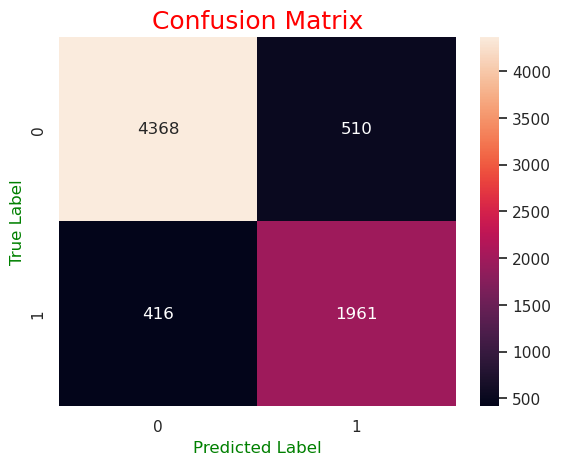


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4368 - Correct non-cancellation predictions
False Positives (FP): 510 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 416 - Missed cancellations
True Positives (TP): 1961 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 82.50% - Actual cancellations detected
Precision (Class 1): 79.36% - Prediction accuracy for cancellations
Specificity (Class 0): 89.54% - Loyal customers correctly identified
False Positive Rate: 10.46% - Loyal customers mistakenly flagged


In [90]:
y_pred = y_pred_over 
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

### XGB

In [91]:
from imblearn.over_sampling import SVMSMOTE

# XGBoost Pipeline with Integrated Over-Sampling
xgb_pipeline_over = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SVMSMOTE(random_state=8818)),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=8818,
        n_jobs=-1,
        eval_metric='logloss'
    ))
])

# Train on ORIGINAL data
xgb_pipeline_over.fit(X_train, y_train)
print("XGBoost trained with integrated over-sampling pipeline")

y_pred_over = xgb_pipeline_over.predict(X_test)

XGBoost trained with integrated over-sampling pipeline


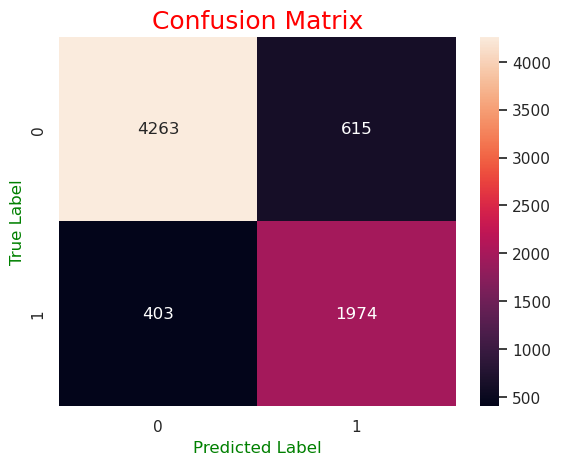


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4263 - Correct non-cancellation predictions
False Positives (FP): 615 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 403 - Missed cancellations
True Positives (TP): 1974 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 83.05% - Actual cancellations detected
Precision (Class 1): 76.25% - Prediction accuracy for cancellations
Specificity (Class 0): 87.39% - Loyal customers correctly identified
False Positive Rate: 12.61% - Loyal customers mistakenly flagged


In [92]:
y_pred = y_pred_over
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

### CatBoost Classifier

In [93]:
from imblearn.over_sampling import SVMSMOTE

# CatBoost Pipeline with Integrated Over-Sampling
catboost_pipeline_over = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SVMSMOTE(random_state=8818)),
    ("model", CatBoostClassifier(
        random_state=8818,
        verbose=100,
        thread_count=-1,
        allow_writing_files=False
    ))
])

# Train on ORIGINAL data
catboost_pipeline_over.fit(X_train, y_train)
print("CatBoost trained with integrated over-sampling pipeline")

y_pred_over = catboost_pipeline_over.predict(X_test)

Learning rate set to 0.049253
0:	learn: 0.6707509	total: 3.9ms	remaining: 3.89s
100:	learn: 0.4180897	total: 297ms	remaining: 2.64s
200:	learn: 0.3703429	total: 616ms	remaining: 2.45s
300:	learn: 0.3428804	total: 908ms	remaining: 2.11s
400:	learn: 0.3239549	total: 1.2s	remaining: 1.79s
500:	learn: 0.3087442	total: 1.5s	remaining: 1.49s
600:	learn: 0.2973916	total: 1.79s	remaining: 1.19s
700:	learn: 0.2876439	total: 2.09s	remaining: 891ms
800:	learn: 0.2788886	total: 2.39s	remaining: 594ms
900:	learn: 0.2712646	total: 2.72s	remaining: 299ms
999:	learn: 0.2649839	total: 3.06s	remaining: 0us
CatBoost trained with integrated over-sampling pipeline


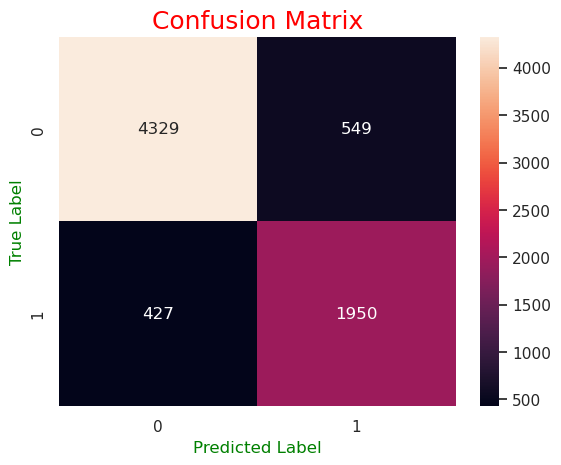


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4329 - Correct non-cancellation predictions
False Positives (FP): 549 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 427 - Missed cancellations
True Positives (TP): 1950 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 82.04% - Actual cancellations detected
Precision (Class 1): 78.03% - Prediction accuracy for cancellations
Specificity (Class 0): 88.75% - Loyal customers correctly identified
False Positive Rate: 11.25% - Loyal customers mistakenly flagged


In [94]:
y_pred = y_pred_over
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

### Voting Classifier

In [95]:
from imblearn.over_sampling import SVMSMOTE

# Voting Classifier Pipeline with Integrated Over-Sampling
voting_pipeline_over = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SVMSMOTE(random_state=8818)),
    ("model", VotingClassifier(
        estimators=[
            ("xgb", XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=8818,
                n_jobs=-1,
                eval_metric='logloss'
            )),
            ("rf", RandomForestClassifier(
                n_estimators=200,
                random_state=8818,
                n_jobs=-1
            )),
            ("cat", CatBoostClassifier(
                random_state=8818,
                verbose=100,
                thread_count=-1,
                allow_writing_files=False
            )) # type: ignore
        ],
        voting="soft",
        weights=[1, 2.5, 1.5]
    ))
])

# Train on ORIGINAL data (over-sampling happens automatically in pipeline)
voting_pipeline_over.fit(X_train, y_train)
print("Voting Classifier trained with integrated over-sampling pipeline")

# Define Prediction according to the new model+pipeline
y_pred_over = voting_pipeline_over.predict(X_test)

Learning rate set to 0.049253
0:	learn: 0.6707509	total: 3.91ms	remaining: 3.9s
100:	learn: 0.4180897	total: 315ms	remaining: 2.8s
200:	learn: 0.3703429	total: 618ms	remaining: 2.46s
300:	learn: 0.3428804	total: 910ms	remaining: 2.11s
400:	learn: 0.3239549	total: 1.22s	remaining: 1.82s
500:	learn: 0.3087442	total: 1.51s	remaining: 1.51s
600:	learn: 0.2973916	total: 1.82s	remaining: 1.21s
700:	learn: 0.2876439	total: 2.11s	remaining: 902ms
800:	learn: 0.2788886	total: 2.41s	remaining: 598ms
900:	learn: 0.2712646	total: 2.71s	remaining: 297ms
999:	learn: 0.2649839	total: 3s	remaining: 0us
Voting Classifier trained with integrated over-sampling pipeline


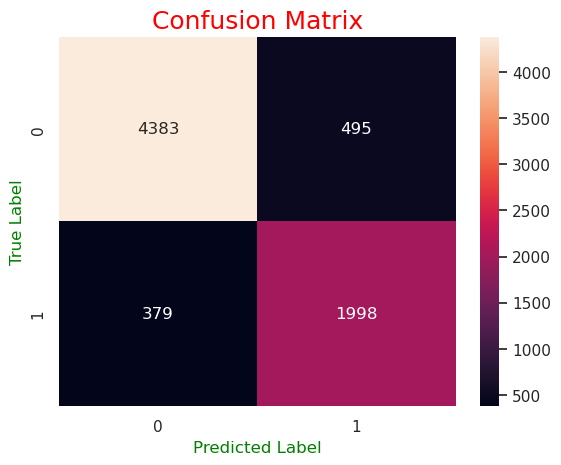


===== CONFUSION MATRIX METRICS =====
True Negatives (TN): 4383 - Correct non-cancellation predictions
False Positives (FP): 495 - False alarms (predicted cancel, but didn't)
False Negatives (FN): 379 - Missed cancellations
True Positives (TP): 1998 - Correctly predicted cancellations

===== KEY BUSINESS METRICS =========
Recall (Class 1): 84.06% - Actual cancellations detected
Precision (Class 1): 80.14% - Prediction accuracy for cancellations
Specificity (Class 0): 89.85% - Loyal customers correctly identified
False Positive Rate: 10.15% - Loyal customers mistakenly flagged


In [96]:
y_pred = y_pred_over
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".0f")
plt.title("Confusion Matrix", color = "red", fontsize=18)
plt.xlabel("Predicted Label", color = "green", fontsize = 12)
plt.ylabel("True Label", color = "green", fontsize = 12)
plt.show()
print_confusion_matrix_analysis(y_test, y_pred)

## SHAP ANALYSIS - HIGH RISK WATERFALL PLOT


SHAP WATERFALL ANALYSIS
✓ Using TreeExplainer
✓ SHAP values calculated for 200 samples

📊 Generating waterfall plot showing top 6 features...


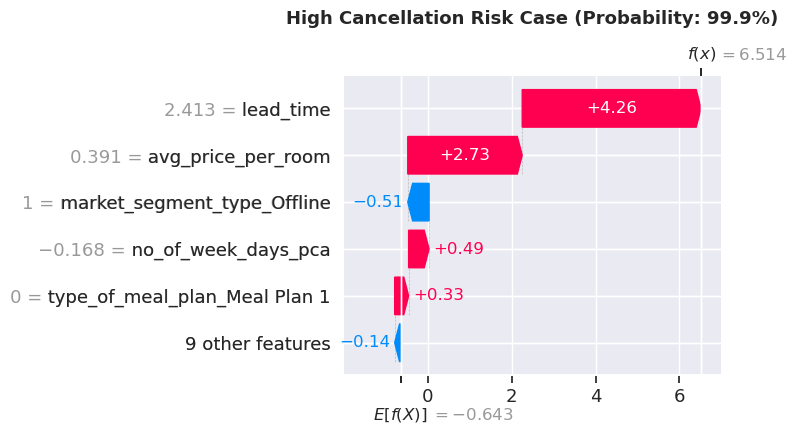


✅ SHAP WATERFALL ANALYSIS COMPLETE!

Generated file:
  • shap_waterfall_high_risk.png

Showing top 6 most impactful features for this prediction

Interpretation Guide:
  🔴 Red bars = Features pushing prediction toward CANCELLATION
  🔵 Blue bars = Features pushing prediction toward NO CANCELLATION
  📊 Bar size = Magnitude of feature's impact on this prediction


In [97]:
# ============================================================================
# SHAP ANALYSIS - HIGH RISK WATERFALL PLOT
# ============================================================================
import shap

# Configuration
TOP_FEATURES = 6  # Number of top features to display in waterfall plot

print("\n" + "="*80)
print("SHAP WATERFALL ANALYSIS")
print("="*80)

# Prepare data for SHAP
X_test_transformed = xgb_pipeline_over.named_steps['preprocessor'].transform(X_test)

# Get feature names after preprocessing
feature_names_shap = []
feature_names_shap.extend(other_numeric_cols)
if pca_people_cols:
    feature_names_shap.append("no_of_people_pca")
if pca_week_cols:
    feature_names_shap.append("no_of_week_days_pca")
cat_encoder = preprocessor.named_transformers_['cat']
feature_names_shap.extend(cat_encoder.get_feature_names_out(categorical_cols))

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names_shap)

# Extract model and create explainer
model_xgb = xgb_pipeline_over.named_steps['model']

# Create background sample for explainer
background = shap.sample(X_test_df, 50, random_state=8818)

# Try TreeExplainer first, fallback to generic Explainer if needed
try:
    explainer = shap.TreeExplainer(model_xgb, background)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠ TreeExplainer failed, using generic Explainer: {e}")
    explainer = shap.Explainer(model_xgb.predict, background)

# Calculate SHAP values for a sample
sample_size = min(200, len(X_test_df))
X_sample = X_test_df.sample(n=sample_size, random_state=8818)

# Get SHAP values
shap_values = explainer(X_sample)
print(f"✓ SHAP values calculated for {sample_size} samples\n")

# Get predicted probabilities to find high risk case
y_pred_proba = model_xgb.predict_proba(X_sample)[:, 1]
high_idx = np.argmax(y_pred_proba)

# Waterfall Plot: High Risk Case
print(f"📊 Generating waterfall plot showing top {TOP_FEATURES} features...")
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[high_idx], max_display=TOP_FEATURES, show=False)
plt.title(f"High Cancellation Risk Case (Probability: {y_pred_proba[high_idx]:.1%})", 
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('./reports/figures/shap_waterfall_high_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ SHAP WATERFALL ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated file:")
print("  • shap_waterfall_high_risk.png")
print(f"\nShowing top {TOP_FEATURES} most impactful features for this prediction")
print("\nInterpretation Guide:")
print("  🔴 Red bars = Features pushing prediction toward CANCELLATION")
print("  🔵 Blue bars = Features pushing prediction toward NO CANCELLATION")
print("  📊 Bar size = Magnitude of feature's impact on this prediction")
print("="*80)   

## Conclusion

### Which Model is Better for Our Business?

We built two different models to predict customer cancellations. The main difference between them comes down to a simple question:

**What's the better mistake to make?**

*   **Mistake A:** Accidentally flag a loyal customer as "at-risk" (a false alarm).
*   **Mistake B:** Miss a customer who was actually about to cancel (a missed opportunity).

Our two models make these mistakes at different rates, and the best choice depends on our business priority.

**Here’s the simple breakdown:**

**Model 1: The "Better Safe Than Sorry" Approach (Undersampling)**
*   **What it does best:** Catches more of the true cancellations. It's like a wide net.
*   **The catch:** It also creates more false alarms, mistakenly labeling 12.7% of our loyal customers as "at-risk."
*   **Best for:** If our main goal is to save every possible cancellation, and we're okay with spending a bit more on retention offers for some loyal customers by accident.

**Model 2: The "Precision Targeting" Approach (Oversampling)**
*   **What it does best:** When it says a customer is cancelling, it's correct more often (80% of the time). It's like a sniper rifle.
*   **The catch:** It misses a few more actual cancellations than Model 1.
*   **Best for:** If we want to use our retention budget efficiently and avoid annoying our loyal customers with unnecessary "please don't leave!" offers.

### Our Recommendation

**We recommend using Model 2 (the Oversampling model).**

**Why?**

Think of it in terms of cost and customer experience:

1.  **It's more cost-effective.** Because it's more accurate when it flags someone, our marketing team can trust its predictions and use their retention budget (like discounts or special offers) more wisely. We're not wasting money on customers who weren't going to leave anyway.

2.  **It's better for customer relationships.** This model bothers far fewer loyal customers with false alarms. There's nothing more frustrating for a happy customer than getting a "we see you're leaving!" message when they had no intention to. This model protects that goodwill.

While Model 1 catches a handful more cancellations, the business benefits of higher efficiency and a better customer experience make Model 2 the smarter long-term choice.

___

## Play with an App 🏨

In [98]:
import joblib

# Save the trained model
joblib.dump(voting_pipeline_over, 'models/voting_classifier_pipeline_model.pkl')

# Save feature names
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'models/feature_names.pkl')

print("Model and feature names saved successfully!")

Model and feature names saved successfully!


Run app.py 

`$ streamlit run app.py`

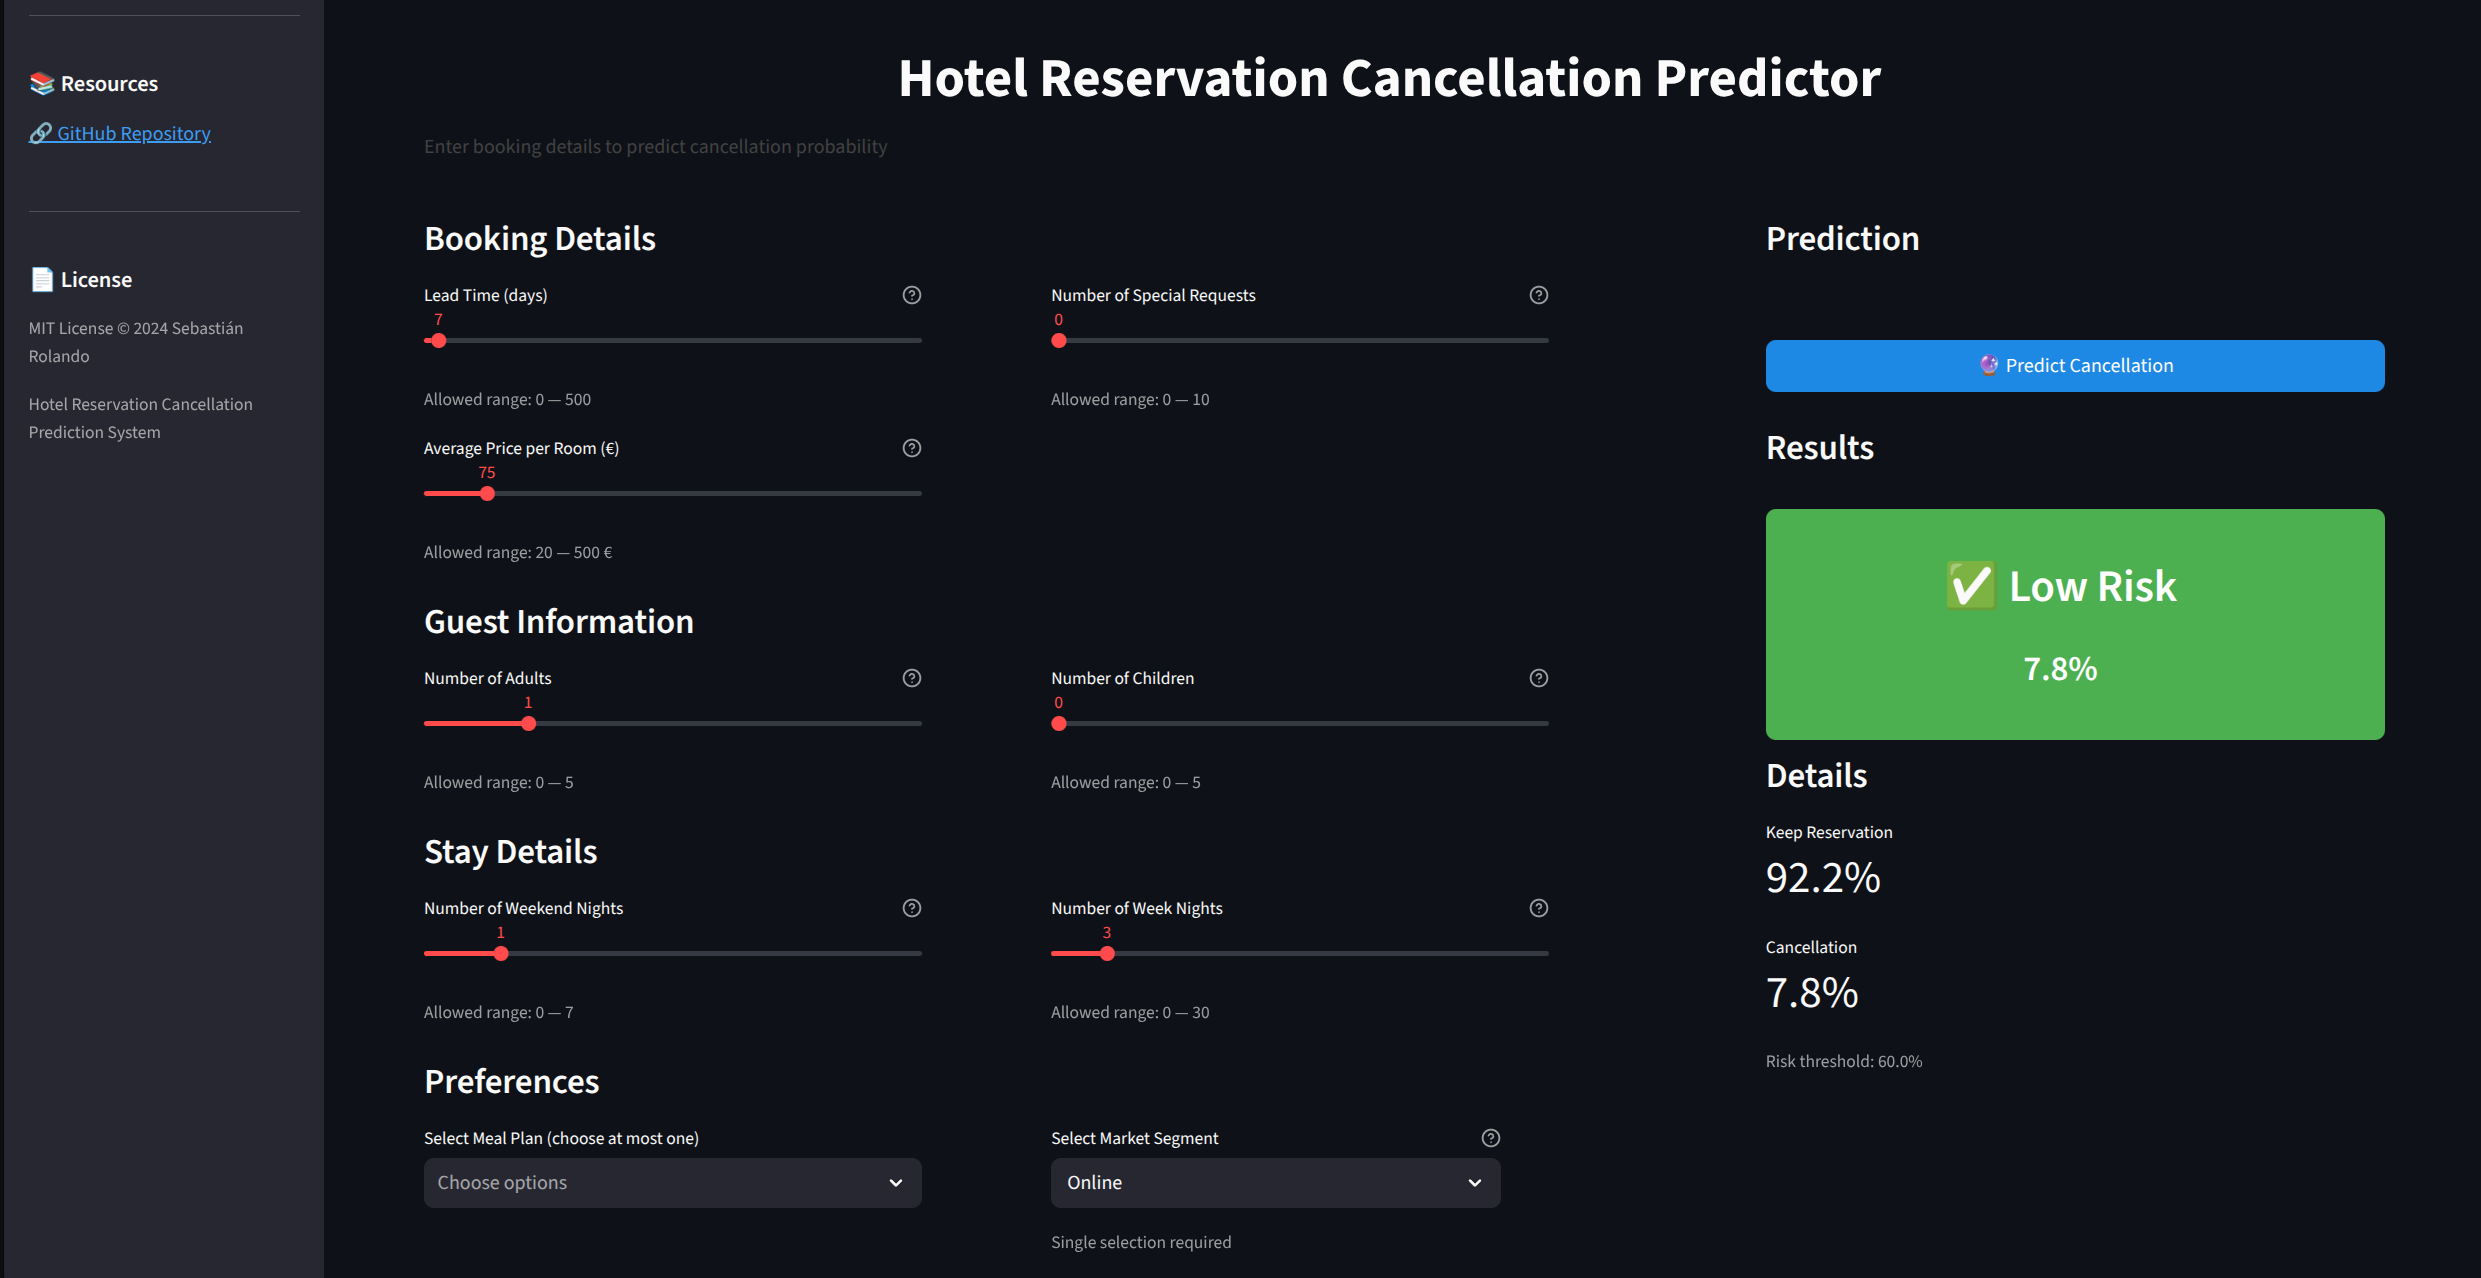